In [ ]:
# %load seg_mrcnn.py
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
#from sklearn.model_selection import KFold
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import skimage.io as io
import skimage.transform as trans

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

DATA_DIR = '/data/krf/dataset'
ROOT_DIR = '/data/krf/model/rsna'

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')
train_seg_dir = os.path.join(DATA_DIR, 'stage_1_train_segmentations')
test_seg_dir = os.path.join(DATA_DIR, 'stage_1_test_segmentations')

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"



def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 



# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100

config = DetectorConfig()
config.display()

class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        pid = fp.split('/')[-1].split('.')[0]
        image = cv2.imread(os.path.join(train_seg_dir,pid+".png"))/255.0
        image = trans.resize(image,(1024,1024))
        #ds = pydicom.read_file(fp)
        #image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()


image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()


# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')


model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])



LEARNING_RATE = 0.004

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")


## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=10,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.0001,
#             epochs=40,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.00001,
#             epochs=60,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)


plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()
plt.savefig(ROOT_DIR+"/log.png")

best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1)


## select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
#for d in dir_names: 
d = dir_names[-1]    
dir_name = os.path.join(model.model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))


class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)


# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            #ds = pydicom.read_file(image_id)
            pid = image_id.split('/')[-1].split('.')[0]
            image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))/255.0
            image = trans.resize(image,(1024,1024))
            #image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'seg_submission1016.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)







Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[109 109 109]
[119 119 119]
[114 114 114]
[105 105 105]
[98 98 98]
[100 100 100]
[101 101 101]
[99 99 99]
[102 102 102]
[104 104 104]
[109 109 109]
[99 99 99]
[92 92 92]
[92 92 92]
[93 93 93]
[96 96 96]
[101 101 101]
[100 100 100]
[89 89 89]
[90 90 90]
[90 90 90]
[89 89 89]
[95 95 95]
[105 105 105]
[104 104 104]
[101 101 101]
[102 102 102]
[105 105 105]
[106 106 106]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[115 115 115]
[117 117 117]
[119 119 119]
[111 111 111]
[105 105 105]
[105 105 105]
[90 90 90]
[88 88 88]
[87 87 87]
[85 85 85]
[88 88 88]
[84 8

[111 111 111]
[112 112 112]
[114 114 114]
[120 120 120]
[122 122 122]
[118 118 118]
[119 119 119]
[119 119 119]
[122 122 122]
[125 125 125]
[138 138 138]
[139 139 139]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[125 125 125]
[107 107 107]
[118 118 118]
[101 101 101]
[92 92 92]
[84 84 84]
[89 89 89]
[93 93 93]
[90 90 90]
[87 87 87]
[87 87 87]
[100 100 100]
[88 88 88]
[83 83 83]
[75 75 75]
[70 70 70]
[74 74 74]
[83 83 83]
[77 77 77]
[83 83 83]
[82 82 82]
[98 98 98]
[109 109 109]
[108 108 108]
[101 101 101]
[103 103 103]
[103 103 103]
[110 110 110]
[109 109 109]
[114 114 114]
[115 115 115]
[120 120 120]
[127 127 127]
[129 129 129]
[123 123 123]
[123 123 123]
[125 125 125]
[129 129 129]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[117 117 117]
[110 110 110]
[106 106 106]
[109 109 109]
[104 104 104]
[91 91 91]
[90 90 

[70 70 70]
[72 72 72]
[69 69 69]
[77 77 77]
[75 75 75]
[76 76 76]
[75 75 75]
[81 81 81]
[82 82 82]
[87 87 87]
[101 101 101]
[99 99 99]
[105 105 105]
[115 115 115]
[122 122 122]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[141 141 141]
[136 136 136]
[132 132 132]
[128 128 128]
[127 127 127]
[118 118 118]
[105 105 105]
[82 82 82]
[78 78 78]
[69 69 69]
[60 60 60]
[63 63 63]
[72 72 72]
[79 79 79]
[79 79 79]
[78 78 78]
[103 103 103]
[91 91 91]
[79 79 79]
[71 71 71]
[71 71 71]
[73 73 73]
[66 66 66]
[71 71 71]
[76 76 76]
[73 73 73]
[78 78 78]
[83 83 83]
[88 88 88]
[83 83 83]
[89 89 89]
[98 98 98]
[94 94 94]
[95 95 95]
[98 98 98]
[106 106 106]
[104 104 104]
[113 113 113]
[114 114 114]
[136 136 136]
[132 132

[0 0 0]
[113 113 113]
[118 118 118]
[95 95 95]
[92 92 92]
[93 93 93]
[97 97 97]
[95 95 95]
[89 89 89]
[91 91 91]
[92 92 92]
[93 93 93]
[82 82 82]
[70 70 70]
[71 71 71]
[71 71 71]
[70 70 70]
[70 70 70]
[66 66 66]
[65 65 65]
[70 70 70]
[75 75 75]
[70 70 70]
[66 66 66]
[61 61 61]
[59 59 59]
[64 64 64]
[60 60 60]
[58 58 58]
[47 47 47]
[48 48 48]
[50 50 50]
[47 47 47]
[54 54 54]
[44 44 44]
[46 46 46]
[45 45 45]
[52 52 52]
[49 49 49]
[49 49 49]
[56 56 56]
[67 67 67]
[72 72 72]
[72 72 72]
[62 62 62]
[64 64 64]
[67 67 67]
[76 76 76]
[81 81 81]
[81 81 81]
[79 79 79]
[95 95 95]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[131 131 131]
[130 130 130]
[125 125 125]
[119 119 119]
[113 113 113]
[102 102 10

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[115 115 115]
[113 113 113]
[107 107 107]
[105 105 105]
[104 104 104]
[108 108 108]
[96 96 96]
[99 99 99]
[90 90 90]
[90 90 90]
[92 92 92]
[95 95 95]
[84 84 84]
[87 87 87]
[75 75 75]
[65 65 65]
[67 67 67]
[65 65 65]
[59 59 59]
[59 59 59]
[59 59 59]
[62 62 62]
[69 69 69]
[65 65 65]
[75 75 75]
[73 73 73]
[71 71 71]
[80 80 80]
[81 81 81]
[68 68 68]
[61 61 61]
[53 53 53]
[52 52 52]
[57 57 57]
[52 52 52]
[49 49 49]
[53 53 53]
[47 47 47]
[57 57 57]
[68 68 68]
[72 72 72]
[83 83 83]
[90 90 90]
[83 83 83]
[74 74 74]
[73 73 73]
[76 76 76]
[86 86 86]
[82 82 82]
[79 79 79]
[84 84 84]
[103 103 103]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[120 120 120]
[112 112 112]
[112 112 112]
[112 112 112]
[109 109 109]
[107 107 107]
[107 107 107]
[103 103 103]
[88 88 88]
[80 80 80]
[81 81 81]
[76 76 76]
[78 78 78]
[69 69 69]
[65 65 65]
[62 62 62]
[62 62 62]
[62 62 62]
[63 63 63]
[59 59 59]
[59 59 59]
[62 62 62]
[73 73 73]
[61 61 61]
[62 62 62]
[66 66 66]
[68 68 68]
[65 65 65]
[64 64 64]
[67 67 67]
[67 67 67]
[68 68 68]
[62 62 62]
[60 60 60]
[59 59 59]
[60 60 60]
[60 

[75 75 75]
[77 77 77]
[78 78 78]
[83 83 83]
[101 101 101]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[139 139 139]
[134 134 134]
[133 133 133]
[125 125 125]
[122 122 122]
[110 110 110]
[94 94 94]
[86 86 86]
[72 72 72]
[62 62 62]
[61 61 61]
[63 63 63]
[76 76 76]
[85 85 85]
[86 86 86]
[93 93 93]
[99 99 99]
[91 91 91]
[82 82 82]
[73 73 73]
[72 72 72]
[74 74 74]
[79 79 79]
[83 83 83]
[88 88 88]
[91 91 91]
[84 84 84]
[92 92 92]
[92 92 92]
[90 90 90]
[99 99 99]
[107 107 107]
[105 105 105]
[106 106 106]
[111 111 111]
[108 108 108]
[101 101 101]
[109 109 109]
[127 127 127]
[128 128 128]
[125 125 125]
[124 124 124]
[129 129 129]
[137 137 137]
[147 147 147]
[0 

[111 111 111]
[113 113 113]
[116 116 116]
[118 118 118]
[120 120 120]
[135 135 135]
[146 146 146]
[140 140 140]
[136 136 136]
[136 136 136]
[134 134 134]
[140 140 140]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[85 85 85]
[74 74 74]
[84 84 84]
[77 77 77]
[70 70 70]
[72 72 72]
[66 66 66]
[63 63 63]
[65 65 65]
[69 69 69]
[64 64 64]
[74 74 74]
[80 80 80]
[91 91 91]
[91 91 91]
[95 95 95]
[82 82 82]
[91 91 91]
[102 102 102]
[93 93 93]
[93 93 93]
[99 99 99]
[113 113 113]
[105 105 105]
[110 110 110]
[116 116 116]
[135 135 135]
[126 126 126]
[117 117 117]
[127 127 127]
[123 123 123]
[127 127 127]
[132 132 132]
[133 133 133]
[142 142 142]
[139 139 139]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[136 136 136]
[135 135 135]
[133 133 133]
[128 128 128]
[113 113 113]
[98 98 98]
[74 74 74]
[73 73 73]
[68 68 68]
[58 58 58]
[61 61 61]
[74 74 74]
[72 72 72]
[75 75 75]
[76 76 76]
[83 83 83]
[85 85 85]
[70 70 70]
[77 77 77]
[78 78 78]
[85 85 85]
[92 92 92]
[96 96 96]
[98 98 98]
[98 98 98]
[98 98 98]
[96 96 96]
[97 97 97]
[121 121 121]
[133 133 133]
[115 115 115]
[110 110 110]
[118 118 118]
[114 114 114]
[120 120 120]
[121 121 121]
[122 122 122]
[129 129 129]
[129 129 129]
[134 134 134]
[128 128 128]
[135 135 135]
[143 143 143]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[118 118 118]
[117 117 117]
[116 116 116]
[116 116 116]
[108 108 108]
[119 119 119]
[103 103 103]
[85 85 85]
[64 64 64]
[60 60 60]
[58 58 58]
[59 59 59]
[64 64 64]
[82 82 82]
[68 68 68]
[72 72 72]
[78 78 78]
[79 79 79]
[83 83 83]
[81 81 81]
[91 91 91]
[108 108 108]
[108 108 108]
[104 104 104]
[123 123 123]
[114 114 114]
[102 102 102]
[105 105 105]
[100 100 100]
[107 107 107]
[121 121 121]
[125 125 125]
[112 112 112]
[120 120 120]
[122 122 122]
[127 127 127]
[127 127 127]
[132 132 132]
[134 134 134]
[136 136 136]
[138 138 138]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[86 86 86]
[82 82 82]
[80 80 80]
[77 77 77]
[83 83 83]
[80 80 80]
[80 80 80]
[80 80 80]
[74 74 74]
[67 67 67]
[66 66 66]
[67 67 67]
[79 79 79]
[79 79 79]
[70 70 70]
[78 78 78]
[79 79 79]
[86 86 86]
[74 74 74]
[64 64 64]
[61 61 61]
[61 61 61]
[69 69 69]
[83 83 83]
[81 81 81]
[88 88 88]
[93 93 93]
[103 103 103]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[130 130 130]
[121 121 121]
[114 114 114]
[111 111 111]
[107 107 107]
[103 103 103]
[103 103 103]
[105 105 105]
[97 97 97]
[88 88 88]
[79 79 79]
[76 76 76]
[85 8

[131 131 131]
[136 136 136]
[137 137 137]
[141 141 141]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[127 127 127]
[131 131 131]
[118 118 118]
[118 118 118]
[120 120 120]
[113 113 1

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[115 115 115]
[117 117 117]
[111 111 111]
[120 120 120]
[119 119 119]
[116 116 116]
[115 115 115]
[98 98 98]
[84 84 84]
[80 80 80]
[85 85 85]
[82 82 82]
[77 77 77]
[70 70 70]
[70 70 70]
[70 70 70]
[73 73 73]
[73 73 73]
[83 83 83]
[76 76 76]
[77 77 77]
[75 75 75]
[75 75 75]
[70 70 70]
[70 70 70]
[86 86 86]
[93 93 93]
[98 98 98]
[99 99 99]
[101 101 101]
[109 109 109]
[113 113 113]
[122 122 122]
[118 118 118]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[128 128 128]
[139 139 139]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[124 124 124]
[117 117 117]
[111 111 111]
[107 107 1

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[144 144 144]
[144 144 144]
[140 140 140]
[138 138 138]
[138 138 138]
[143 143 143]
[139 139 139]
[133 133 133]
[127 127 127]
[134 134 134]
[141 141 141]
[144 144 144]
[145 145 145]
[144 144 144]
[145 145 145]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[97 97 97]
[84 84 84]
[85 85 85]
[83 83 83]
[84 84 84]
[81 81 81]
[84 84 84]
[78 78 78]
[78 78 78]
[79 79 79]
[78 78 78]
[80 80 80]
[80 80 80]
[83 83 83]
[82 82 82]
[80 80 80]
[78 78 78]
[78 78 78]
[76 76 76]
[74 74 74]
[75 75 75]
[73 73 73]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[94 94 94]
[89 89 89]
[85 85 85]
[81 81 81]
[82 82 82]
[80 80 80]
[78 78 78]
[80 80 80]
[77 77 77]
[76 76 76]
[75 75 75]
[78 78 78]
[79 79 79]
[76 76 76]
[75 75 75]
[74 74 74]
[73 73 73]
[70 70 70]
[70 70 70]
[73 73 73]
[74 74 74]
[75 75 75]
[80 80 80]
[83 83 83]
[81 81 81]
[85 85 85]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[124 124 124]
[134 134 134]
[106 106 106]
[91 91 91]
[87 87 87]
[86 86 86]
[90 90 90]
[90 90 90]
[89 89 89]
[90 90 90]
[88 88 88]
[90 90 90]
[89 89 89]
[88 88 88]
[91 91 91]
[85 85 85]
[84 84 84]
[86 86 86]
[84 84 84]
[83 83 83]
[83 83 83]
[83 83 83]
[94 94 94]
[111 111 111]
[113 113 113]
[82 82 82]
[63 63 63]
[62 62 62]
[64 64 64]
[67 67 67]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[84 84 84]
[84 84 84]
[83 83 83]
[96 96 96]
[119 119 119]
[105 105 105]
[97 97 97]
[86 86 86]
[73 73 73]
[78 78 78]
[75 75 75]
[74 74 74]
[70 70 70]
[69 69 69]
[69 69 69]
[68 68 68]
[66 66 66]
[65 65 65]
[64 64 64]
[67 67 67]
[64 64 64]
[63 63 63]
[62 62 62]
[65 65 65]
[65 65 65]
[64 64 64]
[68 68 68]
[64 64 64]
[65 65 65]
[62 62 62]
[60 60 60]
[59 59 59]
[59 59 59]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[125 125 125]
[113 113 113]
[104 104 104]
[98 98 98]
[95 95 95]
[90 90 90]
[77 77 77]
[78 78 78]
[89 89 89]
[86 86 86]
[86 86 86]
[82 82 82]
[74 74 74]
[80 80 80]
[82 82 82]
[87 87 87]
[90 90 90]
[87 87 87]
[87 87 87]
[80 80 80]
[82 82 82]
[74 74 74]
[81 81 81]
[78 78 78]
[76 76 76]
[72 72 72]
[75 75 75]
[81 81 81]
[82 82 82]
[84 84 84]
[95 95 95]
[102 102 102]
[101 101 101]
[99 99 99]
[100 100 100]

[85 85 85]
[84 84 84]
[81 81 81]
[89 89 89]
[98 98 98]
[101 101 101]
[107 107 107]
[112 112 112]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[59 59 59]
[57 57 57]
[54 54 54]
[51 51 51]
[69 69 69]
[59 59 59]
[45 45 45]
[42 42 42]
[40 40 40]
[43 43 43]
[43 43 43]
[44 44 44]
[48 48 48]
[49 49 49]
[51 51 51]
[51 51 51]
[50 50 50]
[50 50 50]
[47 47 47]
[62 62 62]
[63 63 63]
[46 46 46]
[48 48 48]
[47 47 47]
[48 48 48]
[49 49 49]
[51 51 51]
[49 49 49]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[125 125 125]
[106 106 106]
[101 101 101]
[94 94 94]
[95 95 95]
[96 96 96]
[99 99 99]
[107 107 107]
[109 109 109]
[98 98 98]
[95 95 95]
[102 102 102]
[107 107 107]
[108 108 108]
[102 102 102]
[103 103 103]
[95 95 95]
[98 98 98]
[91 91 91]
[91 91 91]
[89 89 89]
[94 94 94]
[89 89 89]
[85 85 85]
[81 81 81]
[83 83 83]
[87 87 87]
[88 88 88]
[84 84 84]
[91 91 91]
[82 82 82]
[75 75 75]
[8

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[128 128 128]
[126 126 126]
[115 115 115]
[115 115 115]
[111 111 111]
[108 108 108]
[108 108 108]
[107 107 107]
[104 104 104]
[113 113 113]
[113 113 113]
[120 120 120]
[115 115 115]
[114 114 114]
[114 114 114]
[119 119 119]
[115 115 115]
[116 116 116]
[127 127 127]
[128 128 128]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[122 122 122]
[122 122 122]
[122 122 122]
[121 121 121]
[121 121 121]
[115 115 115]
[122 122 122]
[112 112 112]
[107 107 107]
[100 100 100]
[101 101 101]
[99 99 99]
[92 92 92]
[101 101 101]
[98 98 98]
[104 104 104]
[100 100 100]
[101 101 101]
[105 105 105]
[97 97 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[122 122 122]
[118 118 118]
[117 117 117]
[112 112 112]
[103 103 103]
[104 104 104]
[106 106 106]
[105 105 105]
[104 104 104]
[109 109 109]
[104 104 104]
[112 112 112]
[102 102 102]
[98 98 98]
[119 119 119]
[121 121 121]
[123 123 123]
[101 101 101]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[138 138 138]
[130 130 130]
[128 128 128]
[129 129 129]
[128 128 128]
[129 129 129]
[136 136 136]
[136 136 136]
[134 134 134]
[134 134 134]
[138 138 138]
[128 128 128]
[117 117 117]
[108 108 108]
[118 118 118]
[127 127 127]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[134 134 134]
[140 140 140]
[148 148 148]
[139 139 139]
[127 127 127]
[131 131 131]
[138 138 138]
[125 125 125]
[129 129 129]
[130 130 130]
[137 137 137]
[134 134 134]
[130 130 130]
[135 135 135]
[132 132 132]
[134 134 134]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[139 139 139]
[137 137 137]
[130 130 130]
[131 131 131]
[123 123 123]
[130 130 130]
[132 132 132]
[133 133 133]
[129 129 129]
[122 122 122]
[128 128 128]
[134 134 134]
[122 122 122]
[126 126 126]
[138 138 138]
[133 133 133]
[121 121 121]
[120 120 120]
[126 126 126]
[126 126 126]
[129 129 129]
[124 124 124]
[125 125 125]
[133 133 133]
[132 132 132]
[132 132 132]
[132 132 132]
[129 129 129]
[131 131 131]
[130 130 130]
[118 118 118]
[118 118 118]
[118 118 118]
[116 116 116]
[111 111 111]
[111 111 111]
[113 113

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[146 146 146]
[149 149 149]
[152 152 152]
[137 137 137]
[134 134 134]
[130 130 130]
[116 116 116]
[106 106 106]
[103 103

[129 129 129]
[135 135 135]
[136 136 136]
[136 136 136]
[137 137 137]
[135 135 135]
[134 134 134]
[136 136 136]
[130 130 130]
[131 131 131]
[119 119 119]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[150 150 150]
[148 148 148]
[145 145 145]
[144 144 144]
[145 145 145]
[141 141 141]
[130 130 130]
[126 126 126]
[115 115 115]
[106 106 106]
[97 97 97]
[108 108 108]
[111 111 111]
[116 116 116]
[110 11

[112 112 112]
[110 110 110]
[117 117 117]
[120 120 120]
[129 129 129]
[136 136 136]
[137 137 137]
[127 127 127]
[127 127 127]
[122 122 122]
[128 128 128]
[138 138 138]
[140 140 140]
[143 143 143]
[147 147 147]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[120 120 120]
[124 124 124]
[128 128 128]
[131 131 131]
[122 122 122]
[116 116 116]
[111 111 111]
[112 112 112]
[108 108 108]
[114 114 114]
[114 114 114]
[111 111 111]
[106 106 106]
[117 117 117]
[117 117 117]
[114 114 114]
[116 116 116]
[125 125 125]
[133 133 133]
[131 131 131]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[127 127 127]
[129 129 129]
[127 127 127]
[123 123 123]
[118 118 118]
[126 126 126]
[120 120 120]
[118 118 118]
[123 123 123]
[108 108 108]
[101 101 101]
[100 100 100]
[106 106 106]
[110 110 110]
[111 111 111]
[112 112 112]
[109 109 109]
[114 114 114]
[115 115 115]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[140 140 140]
[136 136 136]
[138 138 138]
[135 135 135]
[121 121 121]
[121 121 121]
[124 124 124]
[113 113 113]
[116 116 116]
[108 108 108]
[100 100 100]
[100 100 100]
[95 95 95]
[99 99 99]
[107 107 107]
[109 109 109]
[106 106 106]
[107 107 107]
[113 113 113]
[108 108 108]
[109 109 109]
[109 109 109]
[114 114 114]
[109 109 109]
[111 111 111]
[110 110 110]
[112 112 112]
[123 123 123]
[119 119 119]
[120 120 120]
[125 125 125]
[121 121 121]
[120 120 120]
[117 117 117]
[119 119 119]
[116 116 116]
[118 118 118]
[111 111 111]
[105 105 105]
[107 107 107]
[110 110 110]
[109 109 109]
[108 108 108]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[136 136 136]
[135 135 135]
[127 127 127]
[123 123 123]
[115 115 115]
[110 110 110]
[100 100 100]
[101 101 101]
[97 97 97]
[97 97 97]
[98 98 98]
[92 92 92]
[91 91 91]
[99 99 99]
[98 98 98]
[102 102 102]
[95 95 95]
[101 101 101]
[88 88 88]
[90 90 90]
[99 99 99]
[102 102 102]
[99 99 99]
[99 99 99]
[89 89 89]
[79 79 79]
[73 73 73]
[83 83 83]
[89 89 89]
[94 94 94]
[95 95 95]
[101 101 101]
[109 109 109]
[134 134 134]
[127 127 127]
[131 131 131]
[129 129 129]
[127 127 127]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[101 101 101]
[105 105 105]
[95 95 95]
[87 87 87]
[91 91 91]
[85 85 85]
[79 79 79]
[82 82 82]
[82 82 82]
[76 76 76]
[85 85 85]
[88 88 88]
[94 94 94]
[92 92 92]
[99 99 99]
[100 100 100]
[103 103 103]
[103 103 103]
[105 105 105]
[124 124 124]
[138 138 138]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[100 100 100]
[102 102 102]
[106 106 106]
[105 105 105]
[97 97 97]
[99 99 99]
[96 96 96]
[93 93 93]
[87 87 87]
[75 75 75]
[93 93 93]
[98 98 98]
[96 96 96]
[96 96 96]
[88 88 88]
[83 83 83]
[86 86 86]
[100 100 100]
[97 97 97]
[100 100 100]
[99 99 99]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[82 82 82]
[93 93 93]
[99 99 99]
[115 115 115]
[97 97 97]
[84 84 84]
[66 66 66]
[64 64 64]
[81 81 81]
[95 95 95]
[104 104 104]
[114 114 114]
[112 112 112]
[117 117 117]
[121 121 121]
[127 127 127]
[131 131 131]
[126 126 126]
[126 126 126]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[134 134 134]
[130 130 130]
[134 134 134]
[122 122 122]
[96 96 96]
[85 85 85]
[79 79 79]
[83 83 83]
[91 91 91]
[85 85 85]
[86 86 86]
[76 76 76]
[80 80 80]
[75 75 75]
[85 85 85]
[83 83 83]
[69 69 69]
[67 67 67]
[76 76 76]
[87

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[117 117 117]
[111 111 111]
[114 114 114]
[122 122 122]
[121 121 121]
[124 124 124]
[124 124 124]
[118 118 118]
[114 114 114]
[110 110 110]
[108 108 108]
[106 106 106]
[113 113 113]
[112 112 112]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[140 140 140

[101 101 101]
[106 106 106]
[98 98 98]
[105 105 105]
[104 104 104]
[118 118 118]
[108 108 108]
[95 95 95]
[94 94 94]
[66 66 66]
[74 74 74]
[91 91 91]
[78 78 78]
[69 69 69]
[74 74 74]
[66 66 66]
[69 69 69]
[65 65 65]
[57 57 57]
[62 62 62]
[64 64 64]
[69 69 69]
[84 84 84]
[76 76 76]
[80 80 80]
[69 69 69]
[55 55 55]
[62 62 62]
[71 71 71]
[89 89 89]
[97 97 97]
[85 85 85]
[107 107 107]
[78 78 78]
[117 117 117]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[140 140 140]
[119 119 119]
[114 114 114]
[103 103 103]
[102 102 102]
[151 151 151]
[112

[60 60 60]
[62 62 62]
[60 60 60]
[74 74 74]
[64 64 64]
[60 60 60]
[72 72 72]
[67 67 67]
[67 67 67]
[63 63 63]
[64 64 64]
[57 57 57]
[61 61 61]
[58 58 58]
[63 63 63]
[60 60 60]
[58 58 58]
[54 54 54]
[57 57 57]
[59 59 59]
[60 60 60]
[53 53 53]
[59 59 59]
[60 60 60]
[50 50 50]
[50 50 50]
[53 53 53]
[71 71 71]
[69 69 69]
[92 92 92]
[102 102 102]
[83 83 83]
[87 87 87]
[88 88 88]
[89 89 89]
[91 91 91]
[96 96 96]
[102 102 102]
[100 100 100]
[109 109 109]
[108 108 108]
[102 102 102]
[91 91 91]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[159 159 159]
[146 146 146]
[134 134 134]
[132 132 132]
[123 123 123]
[157 157 157]
[122 122 122]
[108 108 108]
[89 89 89]
[76 76 76]
[75 75 75]
[79 79 79]
[80 80 80]
[80 80 80]
[73 73 73]
[74 74 74]
[68 68 68]
[75 75 75]
[78 78 78]
[70 70 70]
[79 79 79]
[93 93 93]
[107 107 107]
[107 107 107]
[99 99 99]
[91 91 91]
[91 91 91]
[92 92 92]
[94 94 94]
[94 94 94]
[95 95 95]
[102 102 102]
[104 104 104]
[110 110 110]
[116 116 116]
[125 125 125]
[128 128 128]
[130 130 130]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[118 118 118]
[127 127 127]
[131 131 131]
[123 123 123]
[145 145 145]
[121 121 121]
[106 106 106]
[101 101 101]
[92 92 92]
[84 84 84]
[84 84 84]
[91 91 91]
[97 97 97]
[98 98 98]
[100 100 100]
[97 97 97]
[100 100 100]
[102 102 102]
[92 92 92]
[96 96 96]
[106 106 106]
[111 111 111]
[113 113 113]
[100 100 100]
[97 97 97]
[92 92 92]
[90 90 90]
[92 92 92]
[102 102 102]
[96 96 96]
[90 90 90]
[81 81 81]
[71 71 71]
[74 74 74]
[69 69 69]
[82 82 82]
[88 88 88]
[91 91 91]
[104 104 104]
[113 113 113]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[118 118 118]
[113 113 113]
[111 111 111]
[111 111 111]
[101 101 101]
[98 98 98]
[83 83 83]
[59 59 59]
[67 67 67]
[60 60 60]
[51 51 51]
[56 56 56]
[58 58 58]
[61 61 61]
[62 62 62]
[47 47 47]
[68 68 68]
[59 59 59]
[54 54 54]
[48 48 48]
[64 64 64]
[60 60 60]
[64 64 64]
[50 50 50]
[52 52 52]
[48 48 48]
[52 52 52]
[53 53 53]
[63 63 63]
[67 67 67]
[57 57 57]
[54 54 54]
[65 65 65]
[84 84 84]
[65 65 65]
[68 68 68]
[79 79 79]
[79 79 79]
[78 78 78]
[95 95 95]
[96 96 96]
[89 89 89]
[84 84 84]
[80 80 80]
[80 80 80]
[78 78 78]
[75 75 75]
[81 81 81]
[74 74 74]
[69 69 69]
[73 73 73]
[59 59 59]
[62 62 62]
[63 63 63]
[73 73 73]
[76 76 76]
[84 84 84]
[97 97 97]
[105 105 105]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[125 125 125]
[170 170 170]
[114 114 114]
[156 156 156]
[133 133 133]
[116 116 116]
[108 108 108]
[105 105 105]
[107 107 107]
[111 111 111]
[95 95 95]
[82 82 82]
[73 73 73]
[73 73 73]
[73 73 73]
[79 79 79]
[77 77 77]
[68 68 68]
[63 63 63]
[78 78 78]
[98 98 98]
[97 97 97]
[89 89 89]
[92 92 92]
[84 84 84]
[84 84 84]
[81 81 81]
[87 87 87]
[100 100 100]
[99 99 99]
[95 95 95]
[77 77 77]
[81 81 81]
[87 87 87]
[105 105 105]
[90 90 90]
[93 93 93]
[86 86 86]
[99 99 99]
[97 97 97]
[98 98 98]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[124 124 124]
[123 123 123]
[110 110 110]
[110 110 110]
[102 102 102]
[79 79 79]
[68 68 68]
[71 71 71]
[72 72 72]
[70 70 70]
[79 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[138 138 138]
[140 140 140]
[131 131 131]
[133 133 133]
[152 152 152]
[125 125 125]
[113 113 113]
[107 107 107]
[115 115 115]
[120 120 120]
[122 122 122]
[124 124 124]
[80 80 80]
[59 59 59]
[56 56 56]
[57 57 57]
[64 64 64]
[79 79 79]
[72 72 72]
[68 68 68]
[66 66 66]
[62 62 62]
[77 77 77]
[87 87 87]
[101 101 101]
[88 88 88]
[85 85 85]
[84 84 84]
[74 74 74]
[103 103 103]
[104 104 104]
[111 111 111]
[108 108 108]
[99 99 99]
[106 106 106]
[95 95 95]
[101 101 101]
[90 90 90]
[92 92 92]
[88 88 88]
[99 99 99]
[109 109 109]
[119 119 119]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[149 149 149]
[148 148 148]
[126 126 126]
[160 160 160]
[115 115 115]
[89 89 89]
[91 91 91]
[99 99 99]
[87 87 87]
[87 87 87]
[93 93 93]
[82 82 82]
[75 75 75]
[75 75 75]
[77 77 77]
[71 71 71]
[77 77 77]
[99 99 99]
[111 111 111]
[100 100 100]
[80 80 80]
[108 108 108]
[95 95 95]
[87 87 87]
[98 98 98]
[93 93 93]
[87 87 87]
[82 82 82]
[96 96 96]
[106 106 106]
[95 95 95]
[93 93 93]
[111 111 111]
[97 97 97]
[95 95 95]
[90 90 90]
[68 68 68]
[72 72 72]
[75 75 75]
[74 74 74]
[77 77 77]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[160 160 160]
[154 154 154]
[136 136 136]
[163 163 163]
[116 116 116]
[98 98 98]
[99 99 99]
[96 96 96]
[91 91 91]
[88 88 88]
[80 80 80]
[78 78 78]
[80 80 80]
[83 83 83]
[100 100 100]
[110 110 110]
[95 95 95]
[87 87 87]
[81 81 81]
[100 100 100]
[92 92 92]
[91 91 91]
[89 89 89]
[107 107 10

[119 119 119]
[126 126 126]
[122 122 122]
[121 121 121]
[113 113 113]
[118 118 118]
[116 116 116]
[113 113 113]
[111 111 111]
[127 127 127]
[136 136 136]
[132 132 132]
[132 132 132]
[120 120 120]
[97 97 97]
[71 71 71]
[75 75 75]
[78 78 78]
[95 95 95]
[83 83 83]
[79 79 79]
[78 78 78]
[77 77 77]
[77 77 77]
[91 91 91]
[101 101 101]
[111 111 111]
[89 89 89]
[71 71 71]
[87 87 87]
[77 77 77]
[79 79 79]
[83 83 83]
[104 104 104]
[108 108 108]
[124 124 124]
[106 106 106]
[106 106 106]
[97 97 97]
[87 87 87]
[86 86 86]
[92 92 92]
[105 105 105]
[119 119 119]
[124 124 124]
[126 126 126]
[123 123 123]
[117 117 117]
[114 114 114]
[117 117 117]
[109 109 109]
[106 106 106]
[100 100 100]
[98 98 98]
[107 107 107]
[110 110 110]
[127 127 127]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[0 0 0]
[0 0 0]
[88 88 88]
[95 95 95]
[100 100 100]
[96 96 96]
[95 95 95]
[98 98 98]
[95 95 95]
[88 88 88]
[97 97 97]
[95 95 95]
[112 112 112]
[97 97 97]
[88 88 88]
[87 87 87]
[61 61 61]
[68 68 68]
[58 58 58]
[73 73 73]
[100 100 100]
[139 139 139]
[147 147 147]
[131 131 131]
[121 121 121]
[108 108 108]
[95 95 95]
[93 93 93]
[104 104 104]
[94 94 94]
[96 96 96]
[91 91 91]
[91 91 91]
[88 88 88]
[90 90 90]
[89 89 89]
[90 90 90]
[91 91 91]
[96 96 96]
[90 90 90]
[90 90 90]
[95 95 95]
[85 85 85]
[83 83 83]
[86 86 86]
[93 93 93]
[99 99 99]
[103 103 103]
[104 104 104]
[93 93 93]
[97 97 97]
[117 117 117]
[131 131 131]
[123 123 123]
[114 114 114]
[113 113 113]
[124 124 124]
[128 128 128]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[101 101 101]
[104 104 104]
[103 103 103]
[112 112 112]
[123 123 123]
[132 132 132]
[133 133 133]
[121 121 121]
[117 117 117]
[95 95 95]
[78 78 78]
[75 75 75]
[77 77 77]
[69 69 69]
[82 82 82]
[77 77 77]
[58 58 58]
[71 71 71]
[78 78 78]
[79 79 79]
[68 68 68]
[78 78 78]
[73 73 73]
[78 78 78]
[84 84 84]
[101 101 101]
[96 96 96]
[79 79 79]
[84 84 84]
[70 70 70]
[86 86 86]
[90 90 90]
[98 98 98]
[96 96 96]
[91 91 91]
[98 98 98]
[94 94 94]
[89 89 89]
[91 91 91]
[96 96 96]
[106 106 106]
[97 97 97]
[110 110 110]
[105 105 105]
[103 103 103]
[112 112 112]
[95 95 95]
[99 99 99]
[104 104 104]
[110 110 110]
[108 108 108]
[113 113 113]
[109 109 109]
[143 143 143]
[134 134 134]
[128 128 128]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[124 124 124]
[97 97 97]
[94 94 94]
[92 92 92]
[98 98 98]
[90 90 90]
[79 79 79]
[76 76 76]
[66 66 66]
[65 65 65]
[62 62 62]
[66 66 66]
[96 96 96]
[84 84 84]
[74 74 74]
[65 65 65]
[54 54 54]
[53 53 53]
[57 57 57]
[52 52 52]
[54 54 54]
[62 62 62]
[68 68 68]
[53 53 53]
[69 69 69]
[60 60 60]
[66 66 66]
[66 66 66]
[65 65 65]
[70 70 70]
[59 59 59]
[71 71 71]
[62 62 62]
[73 73 73]
[80 80 80]
[70 70 70]
[70 70 70]
[72 72 72]
[100 100 100]
[116 116 116]
[125 125 125]
[149 149 149]
[137 137 137]
[120 120 120]
[115 115 115]
[119 119 119]
[122 122 122]
[122 122 122]
[126 126 126]
[135 135 135]
[136 136 136]
[133 133 133]
[121 121 121]
[121 121 121]
[142 142 142]
[133 133 133]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[163 163 163]
[132 132 132]
[129 129 129]
[105 105 105]
[97 97 97]
[100 100 100]
[99 99 99]
[108 108 108]
[104 104 104]
[103 103 103]
[108 108 108]
[119 119 119]
[115 115 115]
[117 117 117]
[120 120 120]
[112 112 112]
[111 111 111]
[96 96 96]
[114 114 114]
[115 115 115]
[112 112 112]
[105 105 105]
[107 107 107]
[106 106 106]
[112 112 112]
[108 108 108]
[89 89 89]
[83 83 83]
[90 90 90]
[85 85 85]
[90 90 90]
[95 95 95]
[100 100 100]
[113 113 113]
[121 121 121]
[109 109 109]
[114 114 114]
[138 138 138]
[157 157 157]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[132 132 132]
[131 131 131]
[129 129 129]
[110 110 110]
[101 101 101]
[123 123 123]
[121 121 121]
[118 118 118]
[114 114 114]
[109 109 109]
[102 102 102]
[101 101 101]
[90 90 90]
[73 73 73]
[64 64 64]
[54 54 54]
[71 71 71]
[67 67 67]
[93 93 93]
[94 94 94]
[84 84 84]
[80 80 80]
[88 88 88]
[94 94 94]
[78 78 78]
[89 89 89]
[81 81 81]
[73 73 73]
[80 80 80]
[75 75 75]
[82 82 82]
[76 76 76]
[80 80 80]
[79 79 79]
[95 95 95]
[89 89 89]
[96 96 96]
[80 80 80]
[83 83 83]
[81 81 81]
[76 76 76]
[87 87 87]
[92 92 92]
[92 92 92]
[94 94 94]
[92 92 92]
[115 115 115]
[140 140 140]
[140 140 140]
[129 129 129]
[121 121 121]
[118 118 118]
[114 114 114]
[112 112 112]
[116 116 116]
[92 92 92]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[154 154 154]
[141 141 141]
[142 142 142]
[141 141 141]
[134 134 134]
[135 135 135]
[131 131 131]
[126 126 126]
[129 129 129]
[127 127 127]
[124 124 124]
[121 121 121]
[121 121 121]
[124 124 124]
[114 114 114]
[116 116 116]
[110 110 110]
[102 102 102]
[95 95 95]
[92 92 92]
[89 89 89]
[89 89 89]
[89 89 89]
[92 92 92]
[86 86 86]
[97 97 97]
[92 92 92]
[86 86 86]
[92 92 92]
[91 91 91]
[95 95 95]
[102 102 102]
[111 111 111]
[126 126 126]
[138 138 138]
[128 128 128]
[122 122 122]
[147 147 147]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[139 139 139]
[145 145 145]
[148 148 148]
[133 133 133]
[128 128 128]
[136 136 136]
[128 128 128]
[128 128 128]
[120 120 120]
[108 108 108]
[123 123 123]
[117 117 117]
[105 105 105]
[100 100 100]
[91 91 91]
[92 92 92]
[92 92 92]
[89 89 89]
[87 87 87]
[81 81 81]
[75 75 75]
[86 86 86]
[88 88 88]
[94 94 94]
[102 102 102]
[93 93 93]
[84 84 84]
[82 82 82]
[87 87 87]
[90 90 90]
[98 98 98]
[115 115 115]
[100 100 100]
[109 109 109]
[119 119 119]
[111 111 111]
[113 113 113]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[145 145 145]
[133 133 133]
[126 126 126]
[130 130 130]
[131 131 131]
[111 111 111]
[116 116 116]
[120 120 120]
[121 121 121]
[119 119 119]
[120 120 120]
[105 105 105]
[100 100 100]
[101 101 101]
[96 96 96]
[100 100 100]
[101 101 101]
[98 98 98]
[91 91 91]
[90 90 90]
[95 95 95]
[94 94 94]
[84 84 84]
[83 83 83]
[86 86 86]
[93 93 93]
[92 92 92]
[107 107 107]
[114 114 114]
[116 116 116]
[116 116 116]
[99 99 99]
[110 110 110]
[119 119 119]
[116 116 116]
[126 126 126]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[139 139 139]
[132 132 132]
[132 132 132]
[130 130 130]
[123 123 123]
[119 119 119]
[110 110 110]
[82 82 82]
[80 80 80]
[96 96 96]
[95 95 95]
[85 85 85]
[101 101 101]
[100 100 100]
[92 92 92]
[92 92 92]
[67 67 67]
[68 68 68]
[82 82 82]
[80 80 80]
[82 82 82]
[83 83 83]
[79 79 79]
[87 87 87]
[82 82 82]
[68 68 68]
[64 64 64]
[73 73 73]
[58 58 58]
[96 96 96]
[128 128 128]
[91 91 91]
[108 108 108]
[108 108 108]
[117 117 117]
[109 109 109]
[104 104 104]
[109 109 109]
[88 88 88]
[88 88 88]
[119 119 119]
[144 144 144]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[126 126 126]
[133 133 133]
[129 129 129]
[116 116 116]
[113 113 113]
[130 130 130]
[101 101 101]
[75 75 75]
[83 83 83]
[81 81 81]
[81 81 81]
[81 81 81]
[86 86 86]
[76 76 76]
[81 81 81]
[92 92 92]
[84 84 84]
[67 67 67]
[61 61 61]
[72 72 72]
[75 75 75]
[81 81 81]
[69 69 69]
[54 54 54]
[88 88 88]
[104 104 104]
[75 75 75]
[81 81 81]
[109 109 109]
[136 136 136]
[124 124 124]
[125 125 125]
[119 119 119]
[107 107 107]
[124 124 124]
[100 100 100]
[121 121 121]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[144 144 144]
[139 139 139]
[130 130 130]
[128 128 128]
[113 113 113]
[106 106 106]
[100 100 100]
[99 99 99]
[51 51 51]
[50 50 50]
[53 53 53]
[60 60 60]
[70 70 70]
[64 64 64]
[74 74 74]
[81 81 81]
[87 87 87]
[102 102 102]
[108 108 108]
[95 95 95]
[89 89 89]
[78 78 78]
[106 106 106]
[120 120 120]
[78 78 78]
[74 74 74]
[71 71 71]
[93 93 93]
[111 111 111]
[126 126 126]
[126 126 126]
[117 117 117]
[115 115 115]
[121 121 121]
[131 131 131]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[125 125 125]
[120 120 120]
[116 116 116

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[101 101 101]
[106 106 106]
[123 123 123]
[119 119 119]
[95 95 95]
[84 84 84]
[98 98 98]
[111 111 111]
[128 128 128]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[94 94 94]
[91 91 91]
[87 87 87]
[86 86 86]
[85 85 85]
[84 84 84]
[84 84 84]
[85 85 85]
[88 88 88]
[90 90 90]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[104 104 104]
[101 101 101]
[99 99 99]
[94 94 94]
[88 88 88]
[80 80 80]
[78 78 78]
[77 77 77]
[81 81 81]
[82 82 82]
[81 81 81]
[81 81 81]
[84 84 84]
[78 78 78]
[67 67 67]
[69 69 69]
[86 86 86]
[86 86 86]
[92 92 92]
[90 90 90]
[89 89 89]
[91 91 91]
[91 91 91]
[89 89 89]
[93 93 93]
[93 93 93]
[98 98 98]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[76 76 76]
[74 74 74]
[87 87 87]
[92 92 92]
[103 103 103]
[101 101 101]
[93 93 93]
[91 91 91]
[102 102 102]
[100 100 100]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[106 106 106]
[103 103 103]
[97 97 97]
[90 90 90]
[83 83 83]
[72 72 72]
[70 70 70]
[72 72 72]
[79 79 79]
[83 83 83]
[94 94 94]
[98 98 98]
[102 102 102]
[100 100 100]
[97 97 97]
[97 97 97]
[93 93 93]
[90 90 90]
[90 90 90]
[93 93 93]
[92 92 92]
[91 91 91]
[91 91 91]
[93 93 93]
[91 91 91]
[92 92 92]
[94 94 94]
[94 94 94]
[94 94 94]
[99 99 99]
[96 96 96]
[99 99 99]
[96 96 96]
[96 96 96]
[100 100 100]
[99 99 99]
[102 102 102]
[102 102 102]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[106 106 106]
[100 100 100]
[94 94 94]
[91 91 91]
[89 89 89]
[84 84 84]
[82 82 82]
[81 81 81]
[82 82 82]
[83 83 83]
[83 83 83]
[82 82 82]
[78 78 78]
[74 74 74]
[80 80 80]
[78 78 78]
[75 75 75]
[79 79 79]
[76 76 76]
[77 77 77]
[82 82 82]
[86 86 86]
[83 83 83]
[83 83 83]
[84 84 84]
[87 87 87]
[89 89 89]
[85 85 85]
[85 85 85]
[87 87 87]
[84 84 84]
[97 97 97]
[95 95 95]
[99 99 99]
[94 94 94]
[98 98 98]
[98 98 98]
[101 101 101]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[112 112 112]
[110 110 110]
[108 108 108]
[105 105 105]
[101 101 101]
[97 97 97]
[96 96 96]
[96 96 96]
[95 95 95]
[88 88 88]
[92 92 92]
[94 94 94]
[86 86 86]
[88 88 88]
[90 90 90]
[90 90 90]
[91 91 91]
[88 88 88]
[84 84 84]
[84 84 84]
[81 81 81]
[80 80 80]
[83 83 83]
[82 82 82]
[82 82 82]
[86 86 86]
[80 80 8

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[104 104 104]
[90 90 90]
[86 86 86]
[84 84 84]
[85 85 85]
[82 82 82]
[83 83 83]
[78 78 78]
[75 75 75]
[78 78 78]
[74 74 74]
[73 73 73]
[76 76 76]
[75 75 75]
[69 69 69]
[70 70 70]
[70 70 70]
[70 70 70]
[75 75 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[102 102 102]
[100 100 100]
[98 98 98]
[97 97 97]
[95 95 95]
[92 92 92]
[86 86 86]
[80 80 80]
[80 80 80]
[76 76 76]
[76 76 76]
[70 70 70]
[69 69 69]
[72 72 72]
[69 69 69]
[67 67 67]
[66 66 66]
[64 64 64]
[63 63 63]
[66 66 66

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[108 108 108]
[106 106 106]
[104 104 104]
[103 103 103]
[98 98 98]
[96 96 96]
[94 94 94]
[91 91 91]
[91 91 91]
[89 89 89]
[89 89 89]
[83 83 83]
[79 79 79]
[75 75 75]
[72 72 72]
[69 69 69]
[67 67 67]
[60 60 60]
[57 57 5

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[115 115 115]
[113 113 113]
[108 108 108]
[101 101 101]
[99 99 99]
[94 94 94]
[92 92 92]
[88 88 88]
[88 88 88]
[80 80 80]
[69 69 69]
[75 75 75]
[80 80 80]
[82 82 82]
[79 79 79]
[85 85 85]
[77 77 77]
[74 74 74]
[77 77 77]
[67 67 67]
[72 72 72]
[77 77 77]
[69 69 69]
[69 69 69]
[67 67 67]
[68 68 68]
[72 72 72]
[72 72 72]
[68 68 68]
[74 74 74]
[77 77 77]
[72 72 72]
[74 74 74]
[77 77 77]
[81 81 81]
[78 78 78]
[80 80 80]
[83 83 83]
[87 87 87]
[88 88 88]
[86 86 86]
[92 92 92]
[97 97 97]
[99 99 99]
[103 103 103]
[106 106 106]
[110 110 110]
[111 111 111]
[115 115 115]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[50 50 50]
[49 49 49]
[49 49 49]
[47 47 47]
[49 49 49]
[58 58 58]
[56 56 56]
[58 58 58]
[61 61 61]
[64 64 64]
[62 62 62]
[74 74 74]
[82 82 82]
[95 95 95]
[99 99 99]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[114 114 114]
[113 113 113]
[112 112 112]
[110 110 110]
[106 106 106]
[100 100 100]
[99 99 99]
[97 97 97]
[96 96 96]
[94 94 94]
[90 90 90]
[75 75 75]
[73 73 73]
[72 72 72]
[68 68 68]
[77 77 77]
[79 79 79]
[76 76 76]
[71 71 71]
[69 69 69]
[56 56 56]
[58 58 58]
[65 65 65]
[65 65 65]
[62 62 62]
[58 58 58]
[59 59 59]
[60 60 60]
[64 64 64]
[65 65 65]
[69 69 69]
[63 63 63]
[73 73 73]
[70 70 70]
[67 67 67]
[67 67 67]
[65 65 65]
[70 70 70]
[69 69 69]
[77 77 77]
[80 80 80]
[88 88 88]
[87 87 87]
[92 92 92]
[101 101 101]
[107 107 107]
[112 112 112]
[115 115 115]
[118 

[57 57 57]
[57 57 57]
[61 61 61]
[58 58 58]
[53 53 53]
[54 54 54]
[55 55 55]
[53 53 53]
[59 59 59]
[55 55 55]
[53 53 53]
[53 53 53]
[58 58 58]
[63 63 63]
[68 68 68]
[78 78 78]
[80 80 80]
[82 82 82]
[87 87 87]
[91 91 91]
[97 97 97]
[101 101 101]
[102 102 102]
[105 105 105]
[105 105 105]
[108 108 108]
[110 110 110]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[51 51 51]
[56 56 56]
[54 54 54]
[50 50 50]
[46 46 46]
[47 47 47]
[51 51 51]
[52 52 52]
[55 55 55]
[56 56 56]
[64 64 64]
[58 58 58]
[57 57 57]
[63 63 63]
[70 70 70]
[75 75 75]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[110 110 110]
[107 107 107]
[105 105 105]
[103 103 103]
[101 101 101]
[98 98 98]
[93 93 93]
[84 84 84]
[74 74 74]
[62 62 62]
[58 58 58]
[45 45 45]
[36 36 36]
[42 42 42]
[42 42 42]
[44 44 44]
[43 43 43]
[45 45 45]
[52 52 52]
[49 49 49]
[51 51 51]
[62 62 62]
[54 54 54]
[49 49 49]
[47 47 47]
[45 45 45]
[47 47 47]
[47 47 47]
[50 50 50]
[49 49 49]
[42 42 42]
[45 45 45]
[49 49 49]
[54 54 54]
[54 54 54]
[51 51 51]
[54 54 54]
[60 60 60]
[66 66 66]
[68 68 68]
[75 75 75]
[80 80 80]
[87 87 87]
[88 88 88]
[90 90 90]
[95 95 95]
[100 100 100]
[99 99 99

[61 61 61]
[65 65 65]
[65 65 65]
[65 65 65]
[60 60 60]
[55 55 55]
[57 57 57]
[62 62 62]
[66 66 66]
[61 61 61]
[64 64 64]
[68 68 68]
[71 71 71]
[76 76 76]
[83 83 83]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[113 113 113]
[112 112 112]
[111 111 111]
[108 108 108]
[108 108 108]
[101 101 101]
[83 83 83]
[78 78 78]
[73 73 73]
[64 64 64]
[57 57 57]
[54 54 54]
[62 62 62]
[62 62 62]
[66 66 66]
[63 63 63]
[70 70 70]
[67 67 67]
[72 72 72]
[65 65 65]
[65 65 65]
[66 66 66]
[73 73 73]
[67 67 67]
[68 68 68]
[58 58 58]
[51 51 51]
[61 61 61]
[61 61 61]
[61 61 61]
[65 65 65]
[73 73 73]
[73 73 73]
[71 71 71]
[74 74 74]
[75 75 75]
[79 79 79]
[83 83 83]
[87 87 87]
[87 87 87]
[87 87 87]
[91 91 91]
[95 95 95]
[95 95 95]
[98 98 98]
[102 102 102]
[109 109 109

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[116 116 116]
[116 116 116]
[112 112 112]
[106 106 106]
[99 99 99]
[97 97 97]
[95 95 95]
[92 92 92]
[91 91 91]
[87 87 87]
[84 84 84]
[84 84 84]
[82 82 82]
[74 74 74]
[68 68 68]
[67 67 67]
[64 64 64]
[61 61 61]
[60 60 60]
[57 57 57]
[55 55 55]
[57 5

[111 111 111]
[110 110 110]
[107 107 107]
[104 104 104]
[100 100 100]
[97 97 97]
[94 94 94]
[91 91 91]
[91 91 91]
[85 85 85]
[84 84 84]
[83 83 83]
[78 78 78]
[77 77 77]
[76 76 76]
[74 74 74]
[71 71 71]
[68 68 68]
[64 64 64]
[61 61 61]
[61 61 61]
[57 57 57]
[60 60 60]
[56 56 56]
[56 56 56]
[49 49 49]
[49 49 49]
[50 50 50]
[51 51 51]
[53 53 53]
[50 50 50]
[43 43 43]
[47 47 47]
[57 57 57]
[54 54 54]
[49 49 49]
[50 50 50]
[53 53 53]
[49 49 49]
[52 52 52]
[60 60 60]
[62 62 62]
[62 62 62]
[61 61 61]
[60 60 60]
[51 51 51]
[53 53 53]
[59 59 59]
[64 64 64]
[68 68 68]
[79 79 79]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[110 110 110]
[109 109 109]
[106 106 106]
[102 102 102]
[99 99 99]
[93 93 93]
[74 74 74]
[67 67 67]
[65 65 65]
[57 57 57

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[109 109 109]
[106 106 106]
[104 104 104]
[101 101 101]
[96 96 96]
[88 88 88]
[87 87 87]
[85 85 85]
[85 85 85]
[86 86 86]
[83 83 83]
[81 81 81]
[80 80 80]
[80 80 80]
[73 73 73]
[70 70 70]
[71 71 71]
[64 64 64]
[68 68 68]
[59 59 59]
[60 60 60]
[57 57 57]
[60 60 60]
[54 54 54]
[52 52 52]
[55 55 55]
[54 54 54]
[62 62 62]
[60 60 60]
[54 54 54]
[42 42 42]
[42 42 42]
[45 45 45]
[42 42 42]
[49 49 49]
[59 59 59]
[60 60 60]
[64 64 64]
[57 57 57]
[55 55 55]
[45 45 45]
[51 51 51]
[55 55 55]
[69 69 69]
[67 67 67]
[62 62 62]
[57 57 57]
[57 57 57]
[58 58 58]
[60 60 60]
[71 71 71]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[76 76 76]
[86 86 86]
[82 82 82]
[74 74 74]
[64 64 64]
[58 58 58]
[68 68 68]
[62 62 62]
[69 69 69]
[74 74 74]
[79 79 79]
[82 82 82]
[82 82 82]
[79 79 79]
[81 81 81]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[109 109 109]
[110 110 110]
[109 109 109]
[102 102 102]
[97 97 97]
[94 94 94]
[88 88 88]
[87 87 87]
[88 88 88]
[88 88 88]
[88 88 88]
[90 90 90]
[87 87 87]
[91 91 91]
[94 94 94]
[94 94 94]
[90 90 90]
[87 87 87]
[81 81 81]
[76 76 76]
[75 75 75]
[74 74 74]
[74 74 74]
[74 74 74]
[75 75 75]
[72 72 72]
[71 71 71]
[78 78 78]
[71 71 71]
[74 74 74]
[70 70 70]
[70 70 70]
[77 77 77]
[81 81 81]
[86 86 86]
[86 86 86]
[87 87 87]
[89 89 89]
[96 96 96]
[95 95 95]
[95 95 95]
[97 97 97]
[96 96 96]
[98 98 98]
[98

[73 73 73]
[77 77 77]
[75 75 75]
[83 83 83]
[83 83 83]
[81 81 81]
[75 75 75]
[71 71 71]
[68 68 68]
[67 67 67]
[66 66 66]
[76 76 76]
[81 81 81]
[88 88 88]
[90 90 90]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[119 119 119]
[116 116 116]
[110 110 110]
[106 106 106]
[103 103 103]
[102 102 102]
[101 101 101]
[98 98 98]
[95 95 95]
[93 93 93]
[97 97 97]
[97 97 97]
[94 94 94]
[87 87 87]
[90 90 90]
[85 85 85]
[83 83 83]
[85 85 85]
[83 83 83]
[83 83 83]
[77 77 77]
[78 78 78]
[77 77 77]
[76 76 76]
[80 80 80]
[83 83 83]
[83 83 83]
[82 82 82]
[84 84 84]
[84 84 84]
[82 82 82]
[85 85 85]
[90 90 90]
[95 95 95]
[95 95 95]
[100 100 100]
[97 97 97]
[98 98 98]
[99 99 99]
[100 100 100]
[103 103 103]
[1

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[119 119 119]
[119 119 119]
[116 116 116]
[114 114 114]
[112 112 112]
[109 109 109]
[110 110 110]
[106 106 106]
[102 102 102]
[101 101 101]
[92 92 92]
[

[76 76 76]
[78 78 78]
[76 76 76]
[75 75 75]
[78 78 78]
[84 84 84]
[87 87 87]
[89 89 89]
[88 88 88]
[92 92 92]
[93 93 93]
[96 96 96]
[98 98 98]
[103 103 103]
[104 104 104]
[113 113 113]
[121 121 121]
[121 121 121]
[123 123 123]
[126 126 126]
[129 129 129]
[128 128 128]
[132 132 132]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[111 111 111]
[110 110 110]
[106 106 106]
[106 106 106]
[101 101 101]
[100 100 100]
[101 101 101]
[101 101 101]
[94 94 94]
[90 90 90]
[88 88 88]
[86 86 86]
[87 87 87]
[84 84 84]
[83 83 83]
[84 84 84]
[82 82 82]
[78 78 78]
[74 74 74]
[75 75 75]
[74 74 74]
[75 75 75]
[73 73 73]
[72

[73 73 73]
[74 74 74]
[79 79 79]
[82 82 82]
[91 91 91]
[95 95 95]
[96 96 96]
[96 96 96]
[92 92 92]
[90 90 90]
[98 98 98]
[101 101 101]
[100 100 100]
[102 102 102]
[101 101 101]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[114 114 114]
[114 114 114]
[117 117 117]
[114 114 114]
[113 113 113]
[113 113 113]
[113 113 113]
[102 102 102]
[98 98 98]
[98 98 98]
[94 94 94]
[91 91 91]
[85 85 85]
[90 90 90]
[92 92 92]
[90 90 90]
[81 81 81]
[81 81 81]
[76 76 76]
[75 75 75]
[72 72 72]
[77 77 77]
[76 76 76]
[77 77 77]
[76 76 76]
[79 79 79]
[79 79 79]
[81 81 81]
[85 85 85]
[81 81 81]
[86 86 86]
[90 90 90]
[90 90 90]
[91 91 91]
[90 90 90]
[94 94 94]
[95

[100 100 100]
[104 104 104]
[98 98 98]
[99 99 99]
[103 103 103]
[102 102 102]
[104 104 104]
[105 105 105]
[107 107 107]
[107 107 107]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[121 121 121]
[119 119 119]
[119 119 119]
[122 122 122]
[116 116 116]
[112 112 112]
[111 111 111]
[107 107 107]
[103 103 103]
[93 93 93]
[89 89 89]
[92 92 92]
[89 89 89]
[92 92 92]
[93 93 93]
[92 92 92]
[86 86 86]
[82 82 82]
[79 79 79]
[85 85 85]
[85 85 85]
[83 83 83]
[79 79 79]
[81 81 81]
[81 81 81]
[91 91 91]
[94 94 94]
[95 95 95]
[96 96 96]
[100 100 100]
[105 105 105]
[110 110 110]
[109 109 109]
[105 105 105]
[105 105 105]
[110 110 110]
[107 107 107]


[77 77 77]
[77 77 77]
[73 73 73]
[75 75 75]
[75 75 75]
[72 72 72]
[74 74 74]
[77 77 77]
[78 78 78]
[81 81 81]
[82 82 82]
[82 82 82]
[86 86 86]
[84 84 84]
[80 80 80]
[80 80 80]
[72 72 72]
[70 70 70]
[73 73 73]
[80 80 80]
[91 91 91]
[97 97 97]
[103 103 103]
[104 104 104]
[102 102 102]
[97 97 97]
[103 103 103]
[106 106 106]
[101 101 101]
[102 102 102]
[102 102 102]
[102 102 102]
[96 96 96]
[89 89 89]
[88 88 88]
[92 92 92]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[113 113 113]
[112 112 112]
[109 109 109]
[107 107 107]
[110 110 110]
[103 103 103]
[101 101 101]
[99 99 99]
[96 96 96]
[91 91 91]
[89 89 89]
[86 86 86]
[85 85 85]
[82 8

[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[124 124 124]
[125 125 125]
[119 119 119]
[121 121 121]
[119 119 119]
[115 115 115]
[112 112 112]
[105 105 105]
[101 101 101]
[99 99 99]
[92 92 92]
[87 87 87]
[86 86 86]
[86 86 86]
[82 82 82]
[80 80 80]
[77 77 77]
[72 72 72]
[74 74 74]
[69 69 69]
[70 70 70]
[62 62 62]
[56 56 56]
[61 61 61]
[57 57 57]
[59 59 59]
[56 56 56]
[53 53 53]
[52 52 52]
[56 56 56]
[54 54 54]
[55 55 55]
[52 52 52]
[51 51 51]
[55 55 55]
[54 54 54]
[60 60 60]
[67 67 67]
[75 75 75]
[88 88 88]
[91 91 91]
[90 90 90]
[91 91 91]
[87 87 87]
[87 87 87]
[87 87 87]
[89 89 89]
[95 95 95]
[99 99 99]
[98 98 98]
[96 96 96]
[97 97 97]
[96 96 96]
[96 96 96]
[95 95 95]
[94 94 94]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[126 126 126]
[125 125 125]
[121 121 121]
[115 115 115]
[113 113 113]
[109 109 109]
[105 105 105]
[103 103 103]
[97 97 97]
[98 98 98]
[95 95 95]
[91 91 91]
[92 92 92]
[88 88 88]
[85 85 85]
[75 75 75]
[71 71 71]
[67 67 67]
[65 65 65]
[60 60 60]
[56 56 56]
[58 58 58]
[55 55 55]
[54 54 54]
[53 53 53]
[52 52 52]
[55 55 55]
[53 53 53]
[51 51 51]
[53 53 53]
[57 57 57]
[56 56 56]
[54 54 54]
[59 59 59]
[58 58 58]
[65 65 65]
[68 68 68]
[76 76 76]
[81 81 81]
[86 86 86]
[87 87 87]
[85 85 85]
[87 87 87]
[92 92 92]
[93 93 93]
[93 93 93]
[92 92 92]
[92 92 92]
[92 92 92]
[90 90 90]
[91 91 91]
[93 93 93]
[95 95 95]
[94 94 94]
[99 99 99]
[107 107 107]
[111 111 111]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[118 118 118]
[114 114 114]
[113 113 113]
[109 109 109]
[110 110 110]
[106 106 106]
[105 105 105]
[104 104 104]
[93 93 93]
[94 94 94]
[90 90 90]
[89 89 89]
[92 92 92]
[90 90 90]
[84 84 84]
[79 79 79]
[80 80 80]
[76 76 76]
[77 77 77]
[77 77 77]
[78 78 78]
[78 78 78]
[72 72 72]
[69 69 69]
[61 61 61]
[58 58 58]
[57 57 57]
[51 51 51]
[49 49 49]
[47 47 47]
[48 48 48]
[50 50 50]
[54 54 54]
[62 62 62]
[67 67 67]
[68 68 68]
[73 73 73]
[76 76 76]
[81 81 81]
[85 85 85]
[82 82 82]
[80 80 80]
[87 87 87]
[89 89 89]
[95 95 95]
[97 97 97]
[98 98 98]
[95 95 95]
[90 90 90]
[90 90 90]
[90 90 90]
[88 88 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[119 119 119]
[118 118 118]
[111 111 111]
[111 111 111]
[108 108 108]
[103 103 103]
[101 101 101]
[99 99 99]
[95 95 95]
[87 87 87]
[84 84 84]
[90 90 90]
[84 84 84]
[85 85 85]
[86 86 86]
[90 90 90]
[88 88 88]
[87 87 87]
[84 84 84]
[80 80 80]
[79 79 79]
[80 80 80]
[80 80 80]
[82 82 82]
[81 81 81]
[78 78 7

[76 76 76]
[75 75 75]
[77 77 77]
[82 82 82]
[87 87 87]
[89 89 89]
[82 82 82]
[73 73 73]
[81 81 81]
[84 84 84]
[85 85 85]
[83 83 83]
[84 84 84]
[86 86 86]
[85 85 85]
[79 79 79]
[74 74 74]
[76 76 76]
[87 87 87]
[98 98 98]
[108 108 108]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[128 128 128]
[125 125 125]
[127 127 127]
[126 126 126]
[125 125 125]
[125 125 125]
[123 123 123]
[122 122 122]
[123 123 123]
[122 122 122]
[118 118 118]
[117 117 117]
[116 116 116]
[115 115 115]
[114 114 114]
[113 113 113]
[113 113 113]
[112 112 112]
[111 111 111]
[110 110 110]
[108 108 108]
[105 105

[74 74 74]
[81 81 81]
[79 79 79]
[80 80 80]
[78 78 78]
[79 79 79]
[85 85 85]
[88 88 88]
[84 84 84]
[91 91 91]
[94 94 94]
[95 95 95]
[86 86 86]
[85 85 85]
[80 80 80]
[78 78 78]
[76 76 76]
[74 74 74]
[71 71 71]
[92 92 92]
[100 100 100]
[105 105 105]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[127 127 127]
[125 125 125]
[126 126 126]
[125 125 125]
[125 125 125]
[125 125 125]
[123 123 123]
[121 121 121]
[121 121 121]
[123 123 123]
[121 121 121]
[121 121 121]
[119 119 119]
[119 119 119]
[118 118 118]
[116 116 116]
[116 116 116]
[119 119 119]
[115 115 115]
[112 1

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[123 123 123]
[125 125 125]
[130 130 130]
[126 126 126]
[123 123 123]
[124 124 124]
[122 122 122]
[120 120 120]
[119 119 119]
[122 122 122]
[121 121 121]
[121 121 121]
[123 123 123]
[121 121 121]
[122 122 122]
[122 122 122]
[119 119 119]
[117 117 117]
[116 116 116]
[116 116 116]
[115 115 115]
[113 113 113]
[111 111 111]
[113 113 113]
[116 116 116]
[115 115 115]
[119 119 119]
[115 115 115]
[118 118 118]
[117 117 117]
[120 120 120]
[122 122 122]
[119 119 119]
[121 121 121]
[123 123 123]
[124 124 124]
[122 122 122]
[124 124 124]
[124 124 124]
[124 124 124]
[126 126 126]
[127 127 127]
[131 131 131]
[133 133 133]
[141 141 141]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[59 59 59]
[60 60 60]
[62 62 62]
[64 64 64]
[58 58 58]
[67 67 67]
[79 79 79]
[81 81 81]
[86 86 86]
[93 93 93]
[91 91 91]
[95 95 95]
[89 89 89]
[83 83 83]
[88 88 88]
[90 90 90]
[90 90 90]
[89 89 89]
[99 99 99]
[109 109 109]
[115 115 115]
[119 119 119]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[128 128 128]
[126 126 126]
[125 125 125]
[126 126 126]
[122 122 122]
[121 121 121]
[120 120 120]
[122 122 122]
[121 121 121]
[120 120 120]
[121 121 121]
[122 122 122]
[122 122 122]
[120 120 120]
[120 120 120]
[11

[65 65 65]
[70 70 70]
[74 74 74]
[75 75 75]
[71 71 71]
[64 64 64]
[64 64 64]
[61 61 61]
[57 57 57]
[60 60 60]
[61 61 61]
[71 71 71]
[72 72 72]
[74 74 74]
[79 79 79]
[77 77 77]
[71 71 71]
[72 72 72]
[73 73 73]
[81 81 81]
[73 73 73]
[94 94 94]
[102 102 102]
[109 109 109]
[112 112 112]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[127 127 127]
[126 126 126]
[126 126 126]
[126 126 126]
[123 123 123]
[124 124 124]
[122 122 122]
[120 120 120]
[123 123 123]
[119 119 119]
[119 119

[72 72 72]
[73 73 73]
[72 72 72]
[76 76 76]
[72 72 72]
[76 76 76]
[81 81 81]
[74 74 74]
[70 70 70]
[69 69 69]
[70 70 70]
[67 67 67]
[70 70 70]
[69 69 69]
[67 67 67]
[61 61 61]
[65 65 65]
[60 60 60]
[60 60 60]
[74 74 74]
[67 67 67]
[67 67 67]
[68 68 68]
[68 68 68]
[62 62 62]
[56 56 56]
[54 54 54]
[54 54 54]
[51 51 51]
[49 49 49]
[51 51 51]
[57 57 57]
[53 53 53]
[55 55 55]
[63 63 63]
[67 67 67]
[68 68 68]
[70 70 70]
[74 74 74]
[88 88 88]
[80 80 80]
[64 64 64]
[62 62 62]
[65 65 65]
[70 70 70]
[73 73 73]
[87 87 87]
[102 102 102]
[100 100 100]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[47 47 47]
[50 50 50]
[50 50 50]
[52 52 52]
[71 71 71]
[70 70 70]
[70 70 70]
[74 74 74]
[74 74 74]
[72 72 72]
[68 68 68]
[64 64 64]
[56 56 56]
[63 63 63]
[62 62 62]
[66 66 66]
[67 67 67]
[71 71 71]
[75 75 75]
[74 74 74]
[92 92 92]
[103 103 103]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[123 123 123]
[123 123 123]
[123 123 123]
[124 124 124]
[120 120 120]
[120 120 120]
[120 120 120]
[

[55 55 55]
[61 61 61]
[67 67 67]
[60 60 60]
[64 64 64]
[65 65 65]
[64 64 64]
[72 72 72]
[72 72 72]
[76 76 76]
[78 78 78]
[63 63 63]
[61 61 61]
[64 64 64]
[74 74 74]
[84 84 84]
[86 86 86]
[86 86 86]
[86 86 86]
[88 88 88]
[95 95 95]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[124 124 124]
[123 123 123]
[114 114 114]
[111 11

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[102 102 102]
[104 104 104]
[109 109 109]
[110 110 110]
[111 111 111]
[111 111 111]
[113 113 113]
[116 116 116]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[72 72 72]
[73 73 73]
[70 70 70]
[68 68 68]
[67 67 67]
[69 69 69]
[64 64 64]
[56 56 56]
[56 56 56]
[54 54 54]
[54 54 54]
[56 56 56]
[57 57 57]
[55 55 55]
[60 60 60]
[61 61 61]
[66 66 66]
[74 74 74]
[80 80 80]
[82 82 82]
[84 84 84]
[88 88 88]
[95 95 95]
[95 95 95]
[100 100 100]
[108 108 108]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[100 100 100]
[93 93 93]
[82 82 82]
[81 81 81]
[77 77 77]
[77 77 77]
[76 76 76]
[79 79 79]
[83 83 83]
[76 76 76]
[72 72 72]
[76 76 76]
[73 73 73]
[73 73 73]
[69 69 69]
[6

[0 0 0]
[130 130 130]
[124 124 124]
[108 108 108]
[95 95 95]
[78 78 78]
[73 73 73]
[73 73 73]
[79 79 79]
[93 93 93]
[88 88 88]
[89 89 89]
[87 87 87]
[84 84 84]
[77 77 77]
[75 75 75]
[72 72 72]
[71 71 71]
[73 73 73]
[75 75 75]
[78 78 78]
[76 76 76]
[79 79 79]
[74 74 74]
[78 78 78]
[78 78 78]
[79 79 79]
[77 77 77]
[79 79 79]
[89 89 89]
[96 96 96]
[90 90 90]
[82 82 82]
[74 74 74]
[80 80 80]
[77 77 77]
[80 80 80]
[83 83 83]
[81 81 81]
[85 85 85]
[83 83 83]
[83 83 83]
[72 72 72]
[71 71 71]
[71 71 71]
[72 72 72]
[72 72 72]
[78 78 78]
[83 83 83]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[84 84 84]
[79 79 79]
[72 72 72]
[66 66 66]
[56 56 56]
[51 51 51]
[53 53 53]
[50 50 50]
[49 49 49]
[52 52 52]
[57 57 57]
[57 57 57]
[61 61 61]
[65 65 65]
[67 67 67]
[65 65 65]
[68 68 68]
[67 67 67]
[79 79 79]
[80 80 80]
[87 87 87]
[88 88 88]
[89 89 89]
[84 84 84]
[88 88 88]
[87 87 87]
[83 83 83]
[87 87 87]
[85 85 85]
[82 82 82]
[81 81 81]
[68 68 68]
[63 63 63]
[68 68 68]
[62 62 62]
[59 59 59]
[64 64 64]
[62 62 62]
[64 64 64]
[65 65 65]
[70 70 70]
[67 67 67]
[68 68 68]
[68 68 68]
[73 73 73]
[73 73 73]
[85 85 85]
[90 90 90]
[88 88 88]
[84 84 84]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[126 126 126]
[107 107 107]
[89 89 89]
[76 76 76]
[69 69 69]
[69 69 69]
[70 70 70]
[65 65 65]
[64 64 64]
[61 61 61]
[59 59 59]
[62 62 62]
[58 58 58]
[58 58 58]
[57 57 57]
[61 61 61]
[58 58 58]
[57 57 57]
[50 50 50]
[41 41 41]
[42 42 42]
[49 49 49]
[55 55 55]
[62 62 62]
[67 67 67]
[59 59 59]
[55 55 55]
[55 55 55]
[53 53 53]
[48 48 48]
[55 55 55]
[60 60 60]
[51 51 51]
[53 53 53]
[56 56 56]
[54 54 54]
[55 55 55]
[57 57 57]
[58 58 58]
[52 52 52]
[55 55 55]
[58 58 58]
[58 58 58]
[60 60 60]
[60 60 60]
[67 67 67]
[86 86 86]
[84 84 84]
[85 85 85]
[87 87 87]
[99 99 99]
[109 109 109]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[77 77 77]
[80 80 80]
[84 84 84]
[85 85 85]
[89 89 89]
[90 90 90]
[98 98 98]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[135 135 135]
[129 129 129]
[125 125 125]
[121 121 121]
[107 107 107]
[92 92 92]
[83 83 83]
[77 77 77]
[78 78 78]
[62 62 62]
[50 50 50]
[52 52 52]
[53 53 53]
[57 57 57]
[61 61 61]
[65 65 65]
[55 55 55]
[53 53 53]
[59 59 59]
[68 68 68]
[62 62 62]
[52 52 52]
[54 54 54]
[57 57 57]
[58 58 58]
[56 56 56]
[51 51 51]
[55 55 55]
[59 59 59]
[61 61 61]
[55 55 55]
[54 54 54]
[54 54 54]
[54 54 54]
[56 56 56]
[53 53 53]
[52 52 52]
[54 54 54]
[53 53 53]
[59 59 59]
[66 66 66]
[60 60 60]
[62 62 62]
[63 63 63]
[65 65 65]
[67 67 67]
[74 74 74]
[64 64 64]
[68 68 68]
[85 85 85]
[87 87 87]
[88 88 88]
[91 91 91]
[98 98 98]
[119 119 119]
[124 124 124]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[48 48 48]
[49 49 49]
[45 45 45]
[43 43 43]
[38 38 38]
[35 35 35]
[40 40 40]
[43 43 43]
[36 36 36]
[43 43 43]
[48 48 48]
[56 56 56]
[48 48 48]
[51 51 51]
[41 41 41]
[38 38 38]
[39 39 39]
[42 42 42]
[45 45 45]
[50 50 50]
[54 54 54]
[58 58 58]
[52 52 52]
[50 50 50]
[52 52 52]
[63 63 63]
[62 62 62]
[56 56 56]
[66 66 66]
[63 63 63]
[60 60 60]
[95 95 95]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[159 159 159]
[157 157 157]
[153 153 153]
[152 152 152]
[143 143 143]
[126 126 126]
[107 107 107]
[106 106 106]
[94 94 94]
[67 67 67]
[60 60 60]
[56 56 56]
[52 52 52]
[45 45 45]
[46 46 46]
[45 45 45]
[40 40 40]
[40 40 40]
[40 40 40]
[46 46 46]
[44 44 44]
[49 49 49]
[47 47 47]
[42 42 42]
[44 44 44]
[47 47 47]
[51 51 51]
[54 54 54]
[42 42 42]
[36 36 36]
[31 31 31]
[32 32 32]
[30 30 30]
[30 30 30]
[34 34 34]
[35 35 35]
[40 

[115 115 115]
[107 107 107]
[103 103 103]
[97 97 97]
[100 100 100]
[103 103 103]
[92 92 92]
[93 93 93]
[92 92 92]
[89 89 89]
[92 92 92]
[85 85 85]
[81 81 81]
[72 72 72]
[73 73 73]
[62 62 62]
[62 62 62]
[66 66 66]
[54 54 54]
[50 50 50]
[53 53 53]
[48 48 48]
[49 49 49]
[61 61 61]
[66 66 66]
[51 51 51]
[44 44 44]
[40 40 40]
[43 43 43]
[42 42 42]
[44 44 44]
[40 40 40]
[40 40 40]
[42 42 42]
[38 38 38]
[44 44 44]
[37 37 37]
[37 37 37]
[54 54 54]
[62 62 62]
[59 59 59]
[59 59 59]
[59 59 59]
[51 51 51]
[59 59 59]
[69 69 69]
[65 65 65]
[65 65 65]
[70 70 70]
[62 62 62]
[57 57 57]
[66 66 66]
[70 70 70]
[73 73 73]
[74 74 74]
[71 71 71]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[154 154 154]
[150 150 150]
[142 142 142]
[135 135 135]
[131 131 131]
[124 124 124]
[115 115 115]
[108 108 108]
[100 100 100]
[85 85 85]
[58 58 5

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[134 134 134]
[121 121 121]
[113 113 113]
[110 110 110]
[108 108 108]
[111 111 111]
[102 102 102]
[100 100 100]
[100 100 100]
[98 98 98]
[93 93 93]
[91 91 91]
[96 96 96]
[80 80 80]
[68 68 68]
[67 67 67]
[60 60 60]
[57 57 57]
[55 55 55]
[49 49 49]
[43 43 43]
[42 42 42]
[38 38 38]
[41 41 41]
[34 34 34]
[33 33 33]
[29 29 29]
[33 33 33]
[33 33 33]
[35 35 35]
[37 37 37]
[33 33 33]
[28 28 28]
[28 28 28]
[32 32 32]
[28 28 28]
[30 30 30]
[28 28 28]
[23 23 23]
[20 20 20]
[25 25 25]
[35 35 35]
[34 34 34]
[44 44 44]
[53 53 53]
[61 61 61]
[60 60 60]
[57 57 57]
[63 63 63]
[67 67 67]
[71 71 71]
[65 65 65]
[61 61 61]
[67 67 67]
[68 68 68]
[85 85 85]
[84 84 84]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[136 136 136]
[134 134 134]
[132 132 132]
[114 114 114]
[98 98 98]
[88 88 88]
[83 83 83]
[81 81 81]
[80 80 80]
[77 77 77]
[80 80 80]
[72 72 72]
[72 72 72]
[65 65 65]
[60 60 60]
[59 59 59]
[54 54 54]
[55 55 55]
[49 49 49]
[47 47 47]
[46 46 46]
[45 45 45]
[39 39 39]
[35 35 35]
[38 38 38]
[38 38 38]
[30 30 30]
[28 28 28]
[27 27 27]
[31 31 31]
[32 32 32]
[24 24 24]
[26 26 26]
[27 27 27]
[26 26 26]
[25 25 25]
[29 29 29]
[28 28 28]
[19 19 19]
[18 18 18]
[24 24 24]
[27 27 27]
[20 20 20]
[20 20 20]
[26 26 26]
[33 33 33]
[32 32 32]
[33 33 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[132 132 132]
[120 120 120]
[107 107 107]
[106 106 106]
[108 108 108]
[102 102 102]
[94 94 94]
[93 93 93]
[94 94 94]
[96 96 96]
[94 94 94]
[83 83 83]
[79 79 79]
[77 77 77]
[78 78 78]
[76 76 76]
[76 76 76]
[72 72 72]
[69 69 69]
[64 64 64]
[65 65 65]
[60 60 

[50 50 50]
[57 57 57]
[54 54 54]
[53 53 53]
[56 56 56]
[63 63 63]
[64 64 64]
[69 69 69]
[65 65 65]
[62 62 62]
[64 64 64]
[66 66 66]
[69 69 69]
[74 74 74]
[75 75 75]
[80 80 80]
[84 84 84]
[93 93 93]
[95 95 95]
[113 113 113]
[123 123 123]
[121 121 121]
[126 126 126]
[134 134 134]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[101 101 101]
[97 97 97]
[99 99 99]
[109 109 109]
[113 113 113]
[112 112 112]
[114 114 114]
[116 116 116]
[110 110 110]
[113 113 113]
[100 100 100]
[103 103 103]
[100 100 100]
[92 92 92]
[80 80 80]
[79 79 79]
[69 69 69]
[43 43 43]
[41 41 41]
[40 40 40]
[42 42 42]
[36 36 36]
[36 36 36]
[38 38 38]
[38 38 38]
[28 28 28]
[29 29 29]
[33 33 33]
[25 25 25]
[28 28 28]
[30 30 30]
[31 31 31]
[29 29 29]
[35 35 35]
[31 31 31]
[33 33 33]
[37 37 37]
[35 35 35]
[40 40 40]
[46 46 46]
[46 46 46]
[55 55 55]
[45 45 45]
[49 49 49]
[60 60 60]
[65 65 65]
[72 72 72]
[74 74 74]
[77 77 77]
[85 85 85]
[85 85 85]
[93 93 93]
[88 88 88]
[89 89 89]
[99 99 99]
[90 90 90]
[93 93 93]
[97 97 97]
[100 100 100]
[107 107 107]
[111 111 111]
[138 138 138]
[140 140 140]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[69 69 69]
[65 65 65]
[70 70 70]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[110 110 110]
[106 106 106]
[111 111 111]
[105 105 105]
[102 102 102]
[103 103 103]
[110 110 110]
[119 119 119]
[125 125 125]
[117 117 117]
[92 92 92]
[69 69 69]
[53 53 53]
[53 53 53]
[56 56 56]
[56 56 56]
[56 56 56]
[55 55 55]
[45 45 45]
[42 42 42]
[42 42 42]
[56 56 56]
[47 47 47]
[38 38 38]
[37 37 37]
[41 41 41]
[38 38 38]
[35 35 35]
[33 33 33]
[36 36 36]
[37 37 37]
[50 50 50]
[59 59 59]
[79 79 79]
[67 67 67]
[56 56 56]
[41 41 41]
[33 33 33]
[31 31 31]
[37 37 37]
[41 41 41]
[40 40 40]
[43 43 43]
[49 49 49]
[48 48 48]
[44 44 44]
[51 51 51]
[56 56 56]
[58 58 58]
[64 64 64]
[67 67 67]
[70 70 70]
[88 88 88]
[92 92 92]
[96 96 96]
[104 104 104]
[106 106 106]
[109 109 109]
[111 111 111]
[121

[56 56 56]
[50 50 50]
[50 50 50]
[45 45 45]
[47 47 47]
[38 38 38]
[42 42 42]
[34 34 34]
[36 36 36]
[37 37 37]
[43 43 43]
[38 38 38]
[44 44 44]
[40 40 40]
[37 37 37]
[38 38 38]
[36 36 36]
[36 36 36]
[40 40 40]
[34 34 34]
[37 37 37]
[42 42 42]
[42 42 42]
[42 42 42]
[41 41 41]
[38 38 38]
[33 33 33]
[35 35 35]
[47 47 47]
[65 65 65]
[81 81 81]
[84 84 84]
[93 93 93]
[100 100 100]
[111 111 111]
[115 115 115]
[113 113 113]
[100 100 100]
[89 89 89]
[77 77 77]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[141 141 141]
[132 132 132]
[127 127 127]
[118 118 118]
[120 120 120]
[128 128 128]
[125 125 125]
[120 120 120]
[112 112 112]
[112 112 112]
[101 101 101]
[86 86 86]
[67 67 67]
[50 50 50]
[55 55 55]
[50 50 50]
[45 45 45]
[45 45 45]
[50 50 50]
[52 52 52]
[53 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[162 162 162]
[164 164 164]
[159 159 159]
[151 151 151]
[148 148 148]
[149 149 149]
[139 139 139]
[125 125 125]
[108 108 108]
[97 97 97]
[78 78 78]
[68 68 68]
[65 65 65]
[65 65 65]
[59 59 59]
[60 60 60]
[61 61 61]
[52 52 52]
[51 51 51]
[51 51 51]
[47 47 47]
[45 45 45]
[42 42 42]
[39 39 39]
[36 36 36]
[36 36 36]
[38 38 38]
[33 33 33]
[38 38 38]
[33 33 33]
[34 34 34]
[32 32 32]
[32 32 32]
[32 32 32]
[34 34 34]
[34 34 34]
[30 30 30]
[30 30 30]
[27 27 27]
[29 29 29]
[33 33 33]
[35 35 35]
[33 33 33]
[38 38 38]
[34 34 34]
[36 36 36]
[37 37 37]
[39 39 39]
[45 45 45]
[59 59 59]
[77 77 77]
[91 91 91]
[90 90 90]
[91 91 91]
[88 88 88]
[78 78 78]
[78 78 78]
[52 52 52]
[45 45 45]
[47 47 47]
[48 48 48]
[58 58 58]
[47 47 47]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[164 164 164]
[155 155 155]
[152 152 152]
[143 143 143]
[136 136 136]
[131 131 131]
[128 128 128]
[118 118 118]
[106 106 106]
[74 74 74]
[68 68 68]
[61 61 61]
[64 64 64]
[61 61 61]
[60 60 60]
[57 57 57]
[52 52 52]
[52 52 52]
[55 55 55]
[53 53 53]
[43 43 43]
[41 41 41]
[44 44 44]
[45 45 45]
[44 44 44]
[45 45 45]
[41 41 41]
[38 38 38]
[39 39 39]
[35 35 35]
[37 37 37]
[34 34 34]
[40 40 40]
[37 37 37]
[35 35 35]
[38 38 38]
[40 40 40]
[36 36 36]
[41 41 41]
[44 44 44]
[45 45 45]
[40 40 40]
[38 38 38]
[39 39 39]
[42 42 42]
[55 55 55]
[64 64 64]
[57 57 57]
[64 64 64]
[71 71 71]
[89 89 89]
[100 100 100

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[156 156 156]
[138 138 138]
[129 129 129]
[123 123 123]
[120 120 120]
[106 106 106]
[91 91 91]
[94 94 94]
[87 87 87]
[83 83 83]
[73 73 73]
[67 67 67]
[65 65 65]
[62 62 62]
[63 63 63]
[52 52 52]
[55 55 55]
[63 63 63]
[68 68 68]
[69 69 69]
[66 66 66]
[67 67 67]
[63 63 63]
[59 59 59]
[60 60 60]
[54 54 54]
[51 51 51]
[55 55 55]
[54 54 54]
[51 51 51]
[55 55 55]
[53 53 53]
[52 52 52]
[49 49 49]
[57 57 57]
[56 56 56]
[5

[64 64 64]
[61 61 61]
[59 59 59]
[65 65 65]
[61 61 61]
[57 57 57]
[62 62 62]
[68 68 68]
[77 77 77]
[80 80 80]
[79 79 79]
[92 92 92]
[110 110 110]
[126 126 126]
[135 135 135]
[138 138 138]
[151 151 151]
[151 151 151]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[142 142 142]
[138 138 138]
[132 132 132]
[120 120 120]


[119 119 119]
[109 109 109]
[107 107 107]
[105 105 105]
[102 102 102]
[103 103 103]
[95 95 95]
[86 86 86]
[62 62 62]
[22 22 22]
[37 37 37]
[35 35 35]
[36 36 36]
[51 51 51]
[60 60 60]
[49 49 49]
[46 46 46]
[41 41 41]
[46 46 46]
[56 56 56]
[57 57 57]
[57 57 57]
[54 54 54]
[58 58 58]
[63 63 63]
[65 65 65]
[68 68 68]
[72 72 72]
[71 71 71]
[72 72 72]
[74 74 74]
[77 77 77]
[80 80 80]
[82 82 82]
[83 83 83]
[92 92 92]
[106 106 106]
[113 113 113]
[116 116 116]
[139 139 139]
[152 152 152]
[154 154 154]
[165 165 165]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[137 137 137]
[171 171 171]
[177 177 177]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[170 170 170]
[145 145 145]
[135 135 135]
[129 129 129]
[123 123 123]
[114 114 114]
[102 102 102]
[94 94 94]
[86 86 86]
[79 79 79]
[79 79 79]
[67 67 67]
[66 66 66]
[67 67 67]
[66 66 66]
[63 63 63]
[59 59 59]
[58 58 58]
[58 58 58]
[59 59 59]
[60 60 60]
[5

[77 77 77]
[77 77 77]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[127 127 127]
[131 131 131]
[132 132 132]
[133 133 133]
[122 122 122]
[125 125 125]
[120 120 120]
[124 124 124]
[123 123 123]
[125 125 125]
[119 119 119]
[109 109 109]
[95 95 95]
[86 86 86]
[85 85 85]
[66 66 66]
[38 38 38]
[27 27 27]
[39 39 39]
[40 40 40]
[42 42 42]
[45 45 45]
[42 42 42]
[48 48 48]
[60 60 60]
[48 48 48]
[54 54 54]
[72 72 72]
[72 72 72]
[75 75 75]
[78 78 78]
[83 83 83]
[80 80 80]
[95 95 95]
[95 95 95]
[97 97 97]
[106 106 106]
[104 104 104]
[105 105 105]
[111 111 111]
[127 127 127]
[122 122 122

[52 52 52]
[59 59 59]
[59 59 59]
[56 56 56]
[56 56 56]
[54 54 54]
[54 54 54]
[49 49 49]
[47 47 47]
[52 52 52]
[42 42 42]
[58 58 58]
[62 62 62]
[61 61 61]
[63 63 63]
[69 69 69]
[66 66 66]
[63 63 63]
[51 51 51]
[55 55 55]
[54 54 54]
[58 58 58]
[69 69 69]
[69 69 69]
[60 60 60]
[68 68 68]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[138 138 138]
[139 139 139]
[139 139 139]
[135 135 135]
[129 129 129]
[124 124 124]
[124 124 124]
[125 125 125]
[121 121 121]
[123 123 123]
[119 119 119]
[108 108 108]
[92 92 92]
[84 84 84]
[76 76 76]
[67 67 67]
[33 33 33]
[32

[109 109 109]
[109 109 109]
[103 103 103]
[95 95 95]
[95 95 95]
[92 92 92]
[88 88 88]
[87 87 87]
[90 90 90]
[90 90 90]
[89 89 89]
[87 87 87]
[88 88 88]
[88 88 88]
[86 86 86]
[78 78 78]
[64 64 64]
[69 69 69]
[66 66 66]
[60 60 60]
[59 59 59]
[60 60 60]
[55 55 55]
[58 58 58]
[48 48 48]
[40 40 40]
[43 43 43]
[46 46 46]
[44 44 44]
[41 41 41]
[43 43 43]
[40 40 40]
[34 34 34]
[41 41 41]
[44 44 44]
[46 46 46]
[47 47 47]
[43 43 43]
[59 59 59]
[50 50 50]
[52 52 52]
[54 54 54]
[51 51 51]
[63 63 63]
[57 57 57]
[64 64 64]
[49 49 49]
[50 50 50]
[59 59 59]
[65 65 65]
[71 71 71]
[71 71 71]
[70 70 70]
[57 57 57]
[60 60 60]
[56 56 56]
[57 57 57]
[65 65 65]
[67 67 67]
[70 70 70]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[125 125 125]
[120 120 120]
[113 113 113]
[106 106 106]
[97 97 97]
[103 103 103]
[107 107 107]
[98 98 98]
[94 94 94]
[86 86 86]
[87 87 87]
[83 83 83]
[80 80 80]
[82 82 82]
[80 80 80]
[68 68 68]
[55 55 55]
[60 60 60]
[67 67 67]
[72 72 72]
[67 67 67]
[67 67 67]
[73 73 73]
[70 70 70]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[90 90 90]
[89 89 89]
[98 98 98]
[101 101 101]
[107 107 107]
[115 115 115]
[114 114 114]
[127 127 127]
[135 135 135]
[141 141 141]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[92 92 92]
[96 96 96]
[93 93 93]
[93 93 93]
[90 90 90]
[93 93 93]
[102 102 102]
[105 105 105]
[116 116 116]
[118 118 118]
[126 126 126]
[130 130 130]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[98 98 98]
[90 90 90]
[88 88 88]
[90 90 90]
[85 85 85]
[88 88 88]
[89 89 89]
[89 89 89]
[89 89 89]
[91 91 91]
[91 91 91]
[92 92 92]
[92 92 92]
[94 94 94]
[91 91 91]
[90 90 90]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[126 126 126]
[123 123 123]
[122 122 122]
[122 122

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[107 107 107]
[110 110 110]
[109 109 109]
[100 100 100]
[100 100 100]
[94 94 94]
[90 90 90]
[90 90 90]
[90 90 90]
[98 98 98]
[106 106 106]
[102 102 102]
[98 98 98]
[94 94 94]
[86 86 86]
[86 86 86]
[86 86 86]
[88 88 88]
[82 82 82]
[84 84 84]
[87 87 87]
[90 90 90]
[85 85 85]
[79 79 79]
[81 81 81]
[80 80 80]
[76 76 76]
[80 80 80]
[83 83 83]
[79 79 79]
[84 84 84]
[85 85 85]
[86 86 86]
[89 89 89]
[90 90 90]
[94 94 94]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[116 116 116]
[107 107 107]
[108 108 108]
[97 97 97]
[92 92 92]
[97 97 97]
[97 97 97]
[91 91 91]
[89 89 89]
[84 84 84]
[83 83 83]
[80 80 80]
[82 82 82]
[83 83 83]
[81 81 81]
[96 96 96]
[99 99 99]
[97 97 97]
[90 90 90]
[90 90 90]
[86 86 86]
[85 85 85]
[87 87 87]
[88 88 88]
[85 85 85]
[88 88 88]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[116 116 116]
[108 108 108]
[109 109 109]
[100 100 100]
[96 96 96]
[93 93 93]
[90 90 90]
[90 90 90]
[89 89 89]
[

[89 89 89]
[89 89 89]
[96 96 96]
[101 101 101]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[98 98 98]
[97 97 97]
[94 94 94]
[88 88 88]
[84 84 84]
[85 85 85]
[85 85 85]
[95 95 95]
[89 89 89]
[82 82 82]
[77 77 77]
[79 79 79]
[80 80 80]
[87 87 87]
[87 87 87]
[87 87 87]
[78 78 78]
[77 77 77]
[82 82 82]
[80 80 80]
[79 79 79]
[76 76 76]
[77 77 77]
[84 84 84]
[91 91 91]
[91 91 91]
[84 84 84]
[81 81 81]
[76 76 76]
[81 81 81]
[81 81 81]
[80 80 80]
[83 83 83]
[75 75 75]
[75 75 75]
[81 81 81]
[84 84 84]
[85 85 85]
[81 81 81]
[78 78 78]
[81 81 81]
[84 84 84]
[84 84 84]
[90 90 90]
[106 106 106]
[98 98 98]
[107 107 107]
[108 108 108]
[112 112 112]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[93 93 93]
[95 95 95]
[89 89 89]
[92 92 92]
[90 90 90]
[96 96 96]
[101 101 101]
[84 84 84]
[84 84 84]
[81 81 81]
[74 74 74]
[86 86 86]
[89 89 89]
[82 82 82]
[82 82 82]
[82 82 82]
[79 79 79]
[80 80 80]
[76 76 76]
[72 72 72]
[75 75 75]
[75 75 75]
[72 72 72]
[73 73 73]
[72 72 72]
[69 69 69]
[70 70 70]
[72 72 72]
[71 71 71]
[70 70 70]
[70 70 70]
[83 83 83]
[80 80 80]
[81 81 81]
[77 77 77]
[77 77 77]
[77 77 77]
[78 78 78]
[81 81 81]
[80 80 80]
[83 83 83]
[92 92 92]
[88 88 88]
[88 88 88]
[90 90 90]
[93 93 93]
[103 103 103]
[117 117 117]
[106 106 106]
[108 108 108]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[77 77 77]
[86 86 86]
[82 82 82]
[86 86 86]
[84 84 84]
[82 82 82]
[86 86 86]
[86 86 86]
[89 89 89]
[85 85 85]
[94 94 94]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[98 98 98]
[99 99 99]
[99 99 99]
[96 96 96]
[95 95 95]
[92 92 92]
[95 95 95]
[94 94 94]
[92 92 92]
[90 90 90]
[91 91 91]
[85 85 85]
[84 84 84]
[84 84 84]
[84 84 84]
[85 85 85]
[81 81 81]
[82 82 82]
[80 80 80]
[80 80 80]
[83 83 83]
[76 76 76]
[75 75 75]
[70 70 70]
[68 68 68]
[70 70 70]
[71 71 71]
[68 68 68]
[61 61 61]
[64 64 64]
[66 66 66]
[66 66 66]
[70 70 70]
[67 67 67]
[66 66 66]
[70 70 70]
[74 74 74]
[75 75 75]
[73 73 73]
[91 91 91]
[93 93 93]
[83 83 83]
[87 87 87]
[89 89 89]
[92 92 92]
[96 96 96]
[101 101 101]

[101 101 101]
[85 85 85]
[85 85 85]
[88 88 88]
[82 82 82]
[79 79 79]
[77 77 77]
[75 75 75]
[78 78 78]
[72 72 72]
[70 70 70]
[76 76 76]
[80 80 80]
[74 74 74]
[74 74 74]
[72 72 72]
[70 70 70]
[69 69 69]
[72 72 72]
[68 68 68]
[71 71 71]
[73 73 73]
[69 69 69]
[69 69 69]
[72 72 72]
[64 64 64]
[63 63 63]
[63 63 63]
[71 71 71]
[69 69 69]
[65 65 65]
[64 64 64]
[64 64 64]
[57 57 57]
[57 57 57]
[58 58 58]
[60 60 60]
[69 69 69]
[74 74 74]
[71 71 71]
[67 67 67]
[70 70 70]
[84 84 84]
[82 82 82]
[87 87 87]
[80 80 80]
[79 79 79]
[79 79 79]
[77 77 77]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[87 87 87]
[87 87 87]
[86 86 86]
[90 90 90]
[85 85 85]
[85 85 85]
[80 80 80]
[79 79 79]
[85 85 85]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[106 106 106]
[95 95 95]
[90 90 90]
[89 89 89]
[88 88 88]
[92 92 92]
[89 89 89]
[81 81 81]
[82 82 82]
[75 75 75]
[79 79 79]
[75 75 75]
[81 81 81]
[79 79 79]
[77 77 77]
[72 72 72]
[77 77 77]
[70 70 70]
[68 68 68]
[67 67 67]
[66 66 66]
[65 65 65]
[64 64 64]
[66 66 66]
[65 65 65]
[62 62 62]
[63 63 63]
[60 60 60]
[65 65 65]
[69 69 69]
[64 64 64]
[66 66 66]
[72 72 72]
[71 71 71]
[65 65 65]
[64 64 64]
[64 64 64]
[65 65 65]
[70 70 70]
[70 70 70]
[66 66 66]
[65 65 65]
[70 70 70]
[69 69 69]
[71 71 71]
[71 71 71]
[80 80 80]
[81 81 81]
[75 75 75]
[78 78 78]
[76 76 76]
[79 79 79]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[112 112 112]
[110 110 110]
[104 104 104]
[98 98 98]
[95 95 95]
[91 91 91]
[96 96 96]
[93 93 93]
[91 91 91]
[87 87 87]
[87 87 87]
[86 86 86]
[75 75 75]
[70 70 70]
[70 70 70]
[70 70 70]
[72 72 72]
[71 71 71]
[67 67 67]
[65 65 65]
[67 67 67]
[68 68 68]
[65 65 65]
[65 65 65]
[60 60 60]
[63 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[110 110 110]
[105 105 105]
[103 103 103]
[106 106 106]
[102 102 102]
[89 89 89]
[85 85 85]
[84 84 84]
[80 80 80]
[79 79 79]
[78 78 78]
[79 79 79]
[81 81 81]
[69 69 69]
[71 71 71]
[66 66 66]
[66 66 66]
[64 64 64]
[66 66 66]
[66 66 66]
[68 68 68]
[70 70 70]
[69 69 

[64 64 64]
[64 64 64]
[62 62 62]
[61 61 61]
[65 65 65]
[65 65 65]
[65 65 65]
[66 66 66]
[72 72 72]
[67 67 67]
[69 69 69]
[68 68 68]
[69 69 69]
[75 75 75]
[75 75 75]
[76 76 76]
[76 76 76]
[75 75 75]
[79 79 79]
[81 81 81]
[84 84 84]
[84 84 84]
[84 84 84]
[85 85 85]
[92 92 92]
[104 104 104]
[109 109 109]
[105 105 105]
[107 107 107]
[112 112 112]
[116 116 116]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[99 99 99]
[95 95 95]
[95 95 95]
[89 89 89]
[87 87 87]
[90 90 90]
[86 86 86]
[87 87 87]
[81 81 81]
[79 79 79]
[79 79 79]
[76 76 76]
[77 77 77]
[76 76 76]
[74 74 74]
[81 81 81]
[73 73 73]
[70 70 70]
[73 73 73]
[68 68 68]
[65 65 65]
[68 68 68]
[67 67 67]
[70 70 70]
[71 71 71]
[68 68 68]
[66 66 66]
[67 67 67]
[62 62 62]
[64 64 64]
[63 63 63]
[61 61 61]
[71 71 71]
[71 71 71]
[64 64 64]
[65 65 65]
[62 62 62]
[58 58 58]
[60 60 60]
[64 64 64]
[67 67 67]
[62 62 62]
[60 60 60]
[67 67 67]
[65 65 65]
[75 75 75]
[70 70 70]
[74 74 74]
[84 84 84]
[97 97 97]
[91 91 91]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[105 105 105]
[97 97 97]
[108 108 108]
[112 112 112]
[95 95 95]
[78 78 78]
[79 79 79]
[77 77 77]
[72 72 72]
[72 72 72]
[71 71 71]
[73 73 73]
[70 70 70]
[69 69 69]
[66 66 66]
[62 62 62]
[65 65 65]
[68 68 68]
[64 64 64]
[64 64 64]
[64 64 64]
[65 65 65]
[69 69 69]
[66 66 66]
[63 63 63]
[67 67 67]
[66 66 66]
[73 73 73]
[70 70 70]
[72 72 72]
[71 71 71]
[74 74 74]
[74 74 74]
[77 77 77]
[72 72 72]
[88 88 88]
[79 79 79]
[80 80 80]
[83 83 83]
[78 78 78]
[78 78 78]
[78 78 78]
[84 84 84]
[84 84 84]
[88 88 88]
[90 90 90]
[92 92 92]
[103 103 103]
[93 93 93]
[98 98 98]
[99 99 99]
[105 105 105]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[0 0 0]
[116 116 116]
[106 106 106]
[92 92 92]
[94 94 94]
[97 97 97]
[96 96 96]
[84 84 84]
[77 77 77]
[81 81 81]
[80 80 80]
[81 81 81]
[86 86 86]
[77 77 77]
[76 76 76]
[72 72 72]
[77 77 77]
[77 77 77]
[73 73 73]
[73 73 73]
[78 78 78]
[73 73 73]
[75 75 75]
[71 71 71]
[66 66 66]
[65 65 65]
[64 64 64]
[68 68 68]
[65 65 65]
[65 65 65]
[67 67 67]
[68 68 68]
[68 68 68]
[67 67 67]
[70 70 70]
[73 73 73]
[70 70 70]
[72 72 72]
[76 76 76]
[78 78 78]
[85 85 85]
[85 85 85]
[86 86 86]
[92 92 92]
[90 90 90]
[91 91 91]
[93 93 93]
[97 97 97]
[103 103 103]
[108 108 108]
[113 113 113]
[112 112 112]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 

[88 88 88]
[91 91 91]
[85 85 85]
[79 79 79]
[81 81 81]
[76 76 76]
[74 74 74]
[74 74 74]
[72 72 72]
[72 72 72]
[74 74 74]
[74 74 74]
[70 70 70]
[71 71 71]
[68 68 68]
[69 69 69]
[71 71 71]
[69 69 69]
[71 71 71]
[72 72 72]
[72 72 72]
[69 69 69]
[71 71 71]
[71 71 71]
[71 71 71]
[69 69 69]
[75 75 75]
[72 72 72]
[71 71 71]
[70 70 70]
[69 69 69]
[80 80 80]
[74 74 74]
[69 69 69]
[69 69 69]
[76 76 76]
[82 82 82]
[83 83 83]
[81 81 81]
[85 85 85]
[97 97 97]
[101 101 101]
[96 96 96]
[96 96 96]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[99 99 99]
[95 95 95]
[87

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[106 106 106]
[105 105 105]
[102 102 102]
[96 96 96]
[90 90 90]
[88 88 88]
[88 88 88]
[84 84 84]
[82 82 82]
[86 86 86]
[82 82 82]
[79 79 79]
[79 79 79]
[79 79 79]
[78 78 78]
[79 79 79]
[76 76 76]
[79 79 79]
[80 80 80]
[80 80 80]
[76 76 76]
[71 71 71]
[70 70 70]
[75 75 75]
[72 72 72]
[77 77 77]
[74 74 74]
[69 69 69]
[71 71 71]
[68 68 68]
[74 74 74]
[73 73 73]
[66 66 66]
[78 78 78]
[78 78 78]
[72 72 72]
[71 71 71]
[73 73 73]
[67 67 67]
[75 75 75]
[80 80 80]
[76 76 76]
[80 80 80]
[88 88 88]
[94 94 94]
[94 94 94]
[91 91 91]
[94 94 94]
[93 93 93]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[121 121 121]
[108 108 108]
[103 103 103]
[99 99 99]
[94 94 94]
[90 90 90]
[91 91 91]
[92 92 92]
[91 91 91]
[93 93 93]
[92 92 92]
[86 86 86]
[81 81 81]
[77 77 77]
[78 78 78]
[79 79 79]
[78 78 78]
[77 77 77]
[78 78 78]
[76 76 76]
[72 72 72]
[72 72 72]
[72 72 72]
[74 74 74]
[68 68 68]
[68 68 68]
[70 70 70]
[72 72 72]
[77 77 77]
[75 75 75]
[72 72 72]
[73 73 73]
[81 81 81]
[79 79 79]
[80 80 80]
[85 85 85]
[85 85 85]
[79 79 79]
[80 80 80]
[92 92 92]
[87 87 87]
[92 92 92]
[91 91 91]
[91 91 91]
[94 94 94]
[102 102 102]
[103 103 103]
[108 108 108]
[104 1

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[123 123 123]
[110 110 110]
[107 107 107]
[104 104 104]
[102 102 102]
[101 101 101]
[93 93 93]
[88 88 88]
[85 85 85]
[88 88 88]
[85 85 85]
[76 76 76]
[77 77 77]
[79 79 79]
[78 78 78]
[84 84 84]
[84 84 84]
[87 87 87]
[81 81 81]
[82 82 82]
[77 77 77]
[73 73 73]
[81 

[82 82 82]
[80 80 80]
[86 86 86]
[86 86 86]
[85 85 85]
[87 87 87]
[91 91 91]
[90 90 90]
[94 94 94]
[93 93 93]
[89 89 89]
[94 94 94]
[103 103 103]
[103 103 103]
[101 101 101]
[104 104 104]
[106 106 106]
[108 108 108]
[108 108 108]
[117 117 117]
[116 116 116]
[122 122 122]
[126 126 126]
[129 129 129]
[130 130 130]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[91 91 91]
[100 100 100]
[101 101 101]
[96 96 96]
[95 95 95]
[87 87 87]
[84 84 84]
[90 90 90]
[91 91 91]
[87 87 87]
[85 85 85]
[92 92 92]
[91 91 91]
[95 95 95]
[90 90 90]
[89 89 89]
[92 92 92]
[93 93 93]
[92 92 92]
[100 100 100]
[106 106 106]
[108 108 108]
[107 107 107]
[112 112 112]
[114 114 114]
[119 119 119]
[123 123 123]
[124 124 124]
[122 122 122]
[123 123 123]
[126 126 126]
[129 129 129]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[102 102 102]
[101 101 101]
[97 97 97]
[95 95 95]
[89 89 89]
[101 101 101]
[97 97 97]
[91 91 91]
[92 92 92]
[93 93 93]
[98 98 98]
[95 95 95]
[91 91 91]
[97 97 97]
[96 96 96]
[91 91 91]
[92 92 92]
[91 91 91]
[93 93 93]
[89 89 89]
[87 87 87]
[89 89 89]
[89 89 89]
[91 91 91]
[86 86 86]
[93 93 93]
[98 98 98]
[93 93 93]
[93 93 93]
[102 102 102]
[97 97 97]
[85 85 85]
[83 

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[101 101 101]
[105 105 105]
[108 108 108]
[108 108 108]
[104 104 104]
[107 107 107]
[110 110 110]
[107 107 107]
[106 106 106]
[110 110 110]
[109 109 109]
[109 109 109]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


KeyboardInterrupt: 

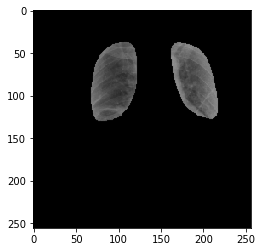

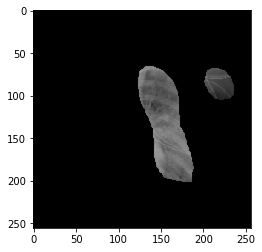

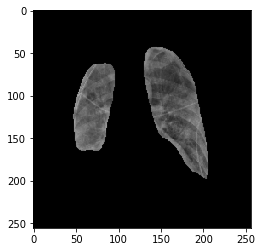

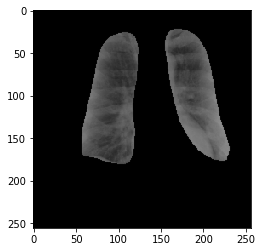

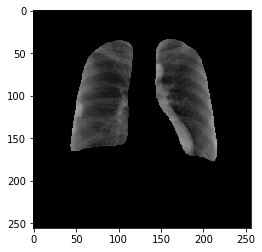

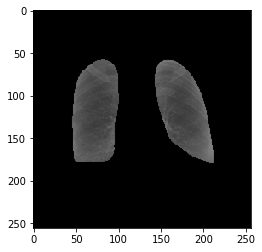

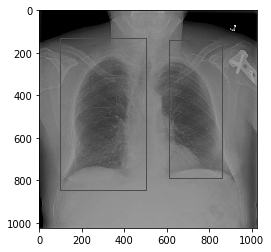

In [28]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    # original image 
    o_image = ds.pixel_array
    #seg
    pid = image_id.split('/')[-1].split('.')[0]
    #print(pid)
    image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))/255.0
    for i in range(256):
        for j in range(256):
            print(image[i,j])
    image = trans.resize(image,(1024,1024))
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)
    plt.imshow(resized_image, cmap=plt.cm.gist_gray)
    results = model.detect([resized_image])
    #print(results[0])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2] * resize_factor)
        cv2.rectangle(o_image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(o_image, cmap=plt.cm.gist_gray)
    #plt.savefig(ROOT_DIR+"/"+patient_id+".png")
show_num =10
for _ in range(show_num):
    visualize()


Using TensorFlow backend.
